# Analisi su multi asset

Architettura di un Hammer e di una Shooting Star su paniere con conferma.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import datetime

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

def load_historical_complete_ffn(tickerlist,startdate,enddate):
    inner_tickerlist =  list(tickerlist.split(","))
    input_string = ""
    for ticker in inner_tickerlist:
        if ticker != "^VIX":
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close," +\
                                          ticker + ":Volume,"
        else:
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close,"
    input_string = input_string[:-1]
    print(input_string)
    #'aapl:Open,aapl:High,aapl:Low,aapl:Close'
    dataset = ffn.get(input_string, start = startdate, end = enddate).apply(lambda x: round(x,2))
    dataset.to_csv("universe_data.csv")
    return dataset

def load_historical_from_csv(filename):
    dataset = pd.read_csv(filename, parse_dates=["Date"])
    dataset.index = dataset.Date
    dataset.drop('Date', axis = 1, inplace = True)
    return dataset

def add_indicators(dataframe):
    service = dataframe.copy()
    service.columns = ["open","high","low","close","volume"]
    service["range_perc"] = (service.high - service.low) / service.low * 100
    service["open_pos"] = (service.open - service.low) / (service.high - service.low) * 100
    service["close_pos"] = (service.close - service.low) / (service.high - service.low) * 100
    service["SMA20"] = service.close.rolling(20).mean()
    service["STD20"] = service.close.rolling(20).std()
    service["BBU"] = service.SMA20 + 2 * service.STD20
    service["BBL"] = service.SMA20 - 2 * service.STD20
    service.dropna(inplace = True)
    #print(service.head(10))
    return service

def pattern_stats(dataframe,pattern,direction,delay,ticker):
    """
    Function to calculate pattern stats
    """
    service = dataframe.copy()
    dates = service[pattern == True].index
    occurrences = service[pattern == True].count()[0]
    print("Occurrences:", occurrences, "\n")
    print(dates,"\n")
    results = []
    for i in range(0, delay):
        label = "st" + str(i + 1)
        if direction == "long":
            service[label] = np.where(pattern.shift(1) == True, service.close.shift(-i) - service.open, np.nan)
        else:
            service[label] = np.where(pattern.shift(1) == True, -service.close.shift(-i) + service.open, np.nan)
        profit = round(service[label].sum(),2)
        avg_profit = round(profit / occurrences, 2)
        winning_trades = service[service[label] > 0].count()[0]
        loosing_trades = service[service[label] <= 0].count()[0]
        print("After:", i + 1,  "days:", profit, "average of", avg_profit, "with", winning_trades, "winning trades and", loosing_trades, "loosing trades")
        results.append(profit)
    plotting_results = pd.DataFrame(results, columns = ["results"], 
                                    index = range(1, delay + 1))
    plotting_results.plot(figsize = [14,8], color = "blue").grid()
    plt.title(ticker + " post pattern inertia")
    plt.show()
    return dates, plotting_results

def pattern_stats_confirmation(dataframe, pattern, direction, delay, ticker):
    """
    Function to calculate pattern stats
    """
    service = dataframe.copy()
    dates = service[pattern == True].index
    occurrences = service[pattern == True].count()[0]
    print("Occurrences:", occurrences, "\n")
    print(dates,"\n")
    results = []
    for i in range(0, delay):
        label = "st" + str(i)
        if direction == "long":
            service[label] = np.where(pattern.shift(1) == True, service.close.shift(-i) - service.high.shift(1), np.nan)
        else:
            service[label] = np.where(pattern.shift(1) == True, -service.close.shift(-i) + service.low.shift(1), np.nan)
        profit = round(service[label].sum(),2)
        avg_profit = round(profit / occurrences, 2)
        winning_trades = service[service[label] > 0].count()[0]
        loosing_trades = service[service[label] <= 0].count()[0]
        print("After:", i + 1,  "days:", profit, "average of", avg_profit, "with", winning_trades, "winning trades and", loosing_trades, "loosing trades")
        results.append(profit)
    plotting_results = pd.DataFrame(results, columns = ["results"], 
                                    index = range(1, delay + 1))
    plotting_results.plot(figsize = [14,8], color = "blue").grid()
    plt.title(ticker + " post pattern inertia")
    plt.show()
    return dates, plotting_results

def plot_patterns(dataframe, results, before, after):
    """
    Function that plots every single pattern occurrence
    """
    for date in results:
        single_case = dataframe[(dataframe.index >= (date - pd.Timedelta(days = before))) & \
                                (dataframe.index <= (date + pd.Timedelta(days = after)))]    
        graph_title = ticker + " from " + str(single_case.index[0]) + " - Powered by Gandalf Project R&D"

        single_case.iplot(kind = 'candle',theme = 'white',
                          up_color = "green", down_color = "red",
                          title = graph_title, xTitle = "Time", yTitle = "Prices")
    return

def create_asset_dataset(matrix):
    """
    Function that slices the original dataframe
    for each single asset
    """
    service = pd.DataFrame(index = matrix.index)
    for column in matrix.columns:
        #print(column)
        if ticker.lower() in column:
            service[column] = matrix[column]
    service = add_indicators(service)
    #print(service)
    return service

def positive_effect(basket_results):
    export = []
    for i in range(1, len(basket_results) + 1):
        positive = []
        for column in basket_results.columns:
            if basket_results[column][i] > 0:
                positive.append(column)
        export.append(positive)
        print("Positive inertia after", i, "bars:", positive)
    return export

In [4]:
load_new_data = False
tickerlist = "MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MSFT,NKE" #,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA,DIS"
startdate = "2007-01-01"
enddate = "2020-11-10"
days_after = 10
show_patterns = False

In [6]:
if load_new_data == True:
    matrix = load_historical_complete_ffn(tickerlist,startdate,enddate)
else:
    matrix = load_historical_from_csv("universe_data.csv")
    #print(matrix)

matrix.to_csv("universe_data.csv")
matrix.head(10)

,mmmopen,mmmhigh,mmmlow,mmmclose,mmmvolume,axpopen,axphigh,axplow,axpclose,axpvolume,...,msftopen,msfthigh,msftlow,msftclose,msftvolume,nkeopen,nkehigh,nkelow,nkeclose,nkevolume
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,77.53,78.85,77.38,78.26,3781500.0,61.18,61.90,60.05,60.36,6142500.0,...,29.91,30.25,29.40,29.86,76935100.0,12.25,12.46,12.10,12.21,17299200.0
2007-01-04,78.40,78.41,77.45,77.95,2968400.0,60.23,60.57,59.79,59.92,5671200.0,...,29.70,29.97,29.44,29.81,45774500.0,12.21,12.37,12.11,12.33,15085600.0
2007-01-05,77.89,77.90,77.01,77.42,2765200.0,59.65,59.87,58.90,59.13,6768100.0,...,29.63,29.75,29.45,29.64,44607200.0,12.26,12.43,12.21,12.35,14996800.0
2007-01-08,77.42,78.04,76.97,77.59,2434500.0,59.03,59.76,58.35,59.69,5000200.0,...,29.65,30.10,29.53,29.93,50220200.0,12.31,12.37,12.20,12.32,10109600.0
2007-01-09,78.00,78.23,77.44,77.68,1896800.0,59.90,59.95,59.00,59.31,4968000.0,...,30.00,30.18,29.73,29.96,44636600.0,12.32,12.49,12.30,12.47,15167200.0
2007-01-10,77.31,77.96,77.04,77.85,1787500.0,59.24,59.37,58.71,59.27,4366800.0,...,29.80,29.89,29.43,29.66,55017400.0,12.40,12.48,12.36,12.47,13012800.0
2007-01-11,78.05,79.03,77.88,78.65,2372500.0,59.25,59.57,59.06,59.45,4204900.0,...,29.76,30.75,29.65,30.70,99464300.0,12.49,12.54,12.43,12.50,14316000.0
2007-01-12,78.41,79.50,78.22,79.36,2582200.0,59.35,59.41,58.76,59.01,5002900.0,...,30.65,31.39,30.64,31.21,103972500.0,12.44,12.50,12.41,12.47,9296800.0
2007-01-16,79.48,79.62,78.92,79.56,2526600.0,58.85,59.18,58.68,59.13,5354200.0,...,31.26,31.45,31.03,31.16,62379600.0,12.44,12.50,12.40,12.50,9264800.0


# <span style="color:green">Esempio pattern "Hammer con conferma"</span>

Pattern analysis on: MMM

Occurrences: 3 

DatetimeIndex(['2008-07-01', '2013-04-30', '2020-05-15'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 4.18 average of 1.39 with 1 winning trades and 2 loosing trades
After: 2 days: 5.76 average of 1.92 with 2 winning trades and 1 loosing trades
After: 3 days: 9.24 average of 3.08 with 2 winning trades and 1 loosing trades
After: 4 days: 6.56 average of 2.19 with 3 winning trades and 0 loosing trades
After: 5 days: 4.97 average of 1.66 with 2 winning trades and 1 loosing trades
After: 6 days: 11.08 average of 3.69 with 2 winning trades and 1 loosing trades
After: 7 days: 18.67 average of 6.22 with 2 winning trades and 1 loosing trades
After: 8 days: 18.2 average of 6.07 with 2 winning trades and 1 loosing trades
After: 9 days: 16.51 average of 5.5 with 2 winning trades and 1 loosing trades
After: 10 days: 16.69 average of 5.56 with 2 winning trades and 1 loosing trades


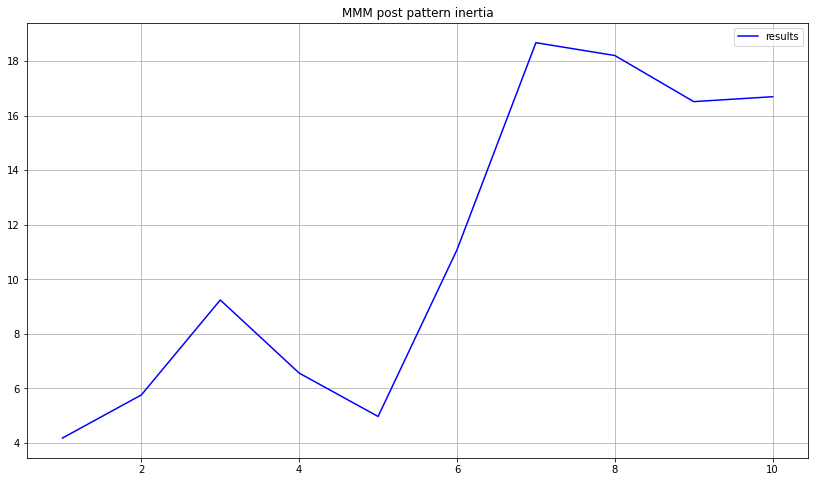


Pattern analysis on: AXP

Occurrences: 6 

DatetimeIndex(['2007-12-14', '2009-02-13', '2011-10-06', '2012-05-24',
               '2013-04-18', '2014-07-29'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -1.96 average of -0.33 with 2 winning trades and 4 loosing trades
After: 2 days: -2.94 average of -0.49 with 3 winning trades and 3 loosing trades
After: 3 days: -5.57 average of -0.93 with 2 winning trades and 4 loosing trades
After: 4 days: -4.28 average of -0.71 with 2 winning trades and 4 loosing trades
After: 5 days: -7.14 average of -1.19 with 2 winning trades and 4 loosing trades
After: 6 days: -4.87 average of -0.81 with 3 winning trades and 3 loosing trades
After: 7 days: -6.77 average of -1.13 with 3 winning trades and 3 loosing trades
After: 8 days: -3.88 average of -0.65 with 2 winning trades and 4 loosing trades
After: 9 days: -5.99 average of -1.0 with 2 winning trades and 4 loosing trades
After: 10 days: -3.9 average of -0.65 with 2 winn

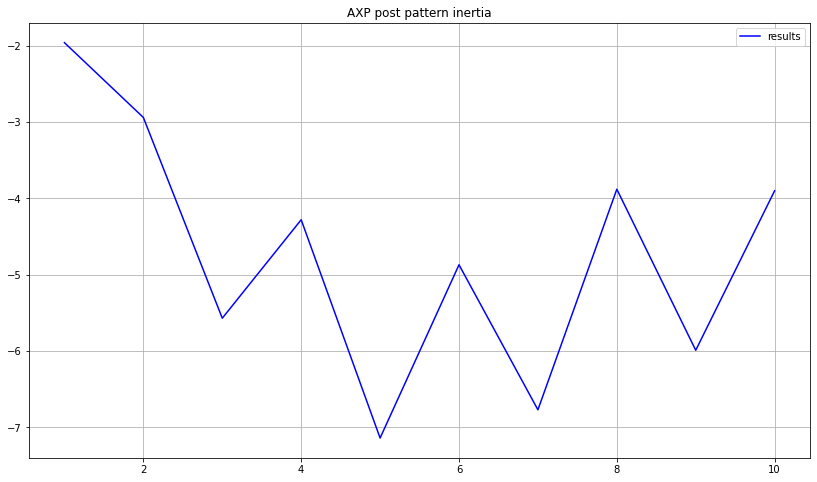


Pattern analysis on: AAPL

Occurrences: 4 

DatetimeIndex(['2010-08-30', '2012-10-10', '2015-10-02', '2015-12-17'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -1.12 average of -0.28 with 2 winning trades and 2 loosing trades
After: 2 days: -0.34 average of -0.08 with 2 winning trades and 2 loosing trades
After: 3 days: -0.25 average of -0.06 with 2 winning trades and 2 loosing trades
After: 4 days: 0.55 average of 0.14 with 2 winning trades and 2 loosing trades
After: 5 days: 0.84 average of 0.21 with 2 winning trades and 2 loosing trades
After: 6 days: 0.15 average of 0.04 with 2 winning trades and 2 loosing trades
After: 7 days: -0.12 average of -0.03 with 2 winning trades and 2 loosing trades
After: 8 days: 0.0 average of 0.0 with 2 winning trades and 2 loosing trades
After: 9 days: -0.69 average of -0.17 with 2 winning trades and 2 loosing trades
After: 10 days: -0.73 average of -0.18 with 2 winning trades and 2 loosing trades


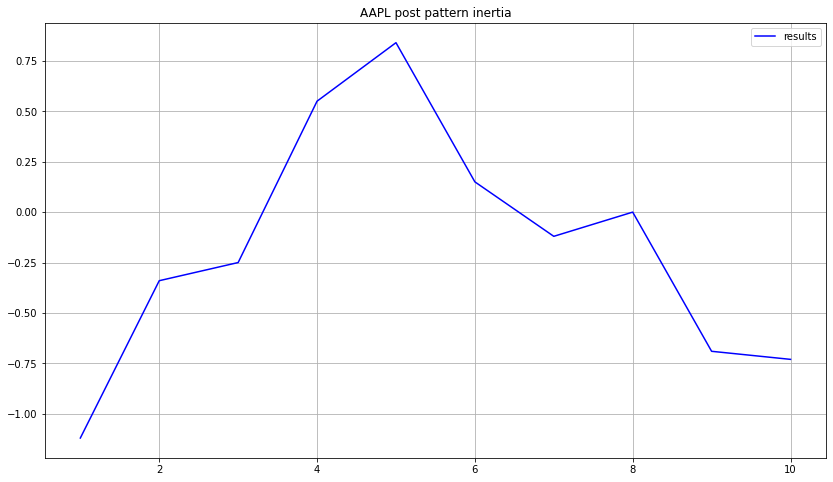


Pattern analysis on: BA

Occurrences: 7 

DatetimeIndex(['2008-03-05', '2009-02-13', '2014-02-06', '2014-10-16',
               '2015-08-13', '2018-02-12', '2018-03-19'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 11.34 average of 1.62 with 5 winning trades and 2 loosing trades
After: 2 days: 9.7 average of 1.39 with 4 winning trades and 3 loosing trades
After: 3 days: 7.16 average of 1.02 with 3 winning trades and 4 loosing trades
After: 4 days: -4.69 average of -0.67 with 2 winning trades and 5 loosing trades
After: 5 days: -4.96 average of -0.71 with 2 winning trades and 5 loosing trades
After: 6 days: -15.52 average of -2.22 with 3 winning trades and 4 loosing trades
After: 7 days: -16.72 average of -2.39 with 3 winning trades and 4 loosing trades
After: 8 days: -12.51 average of -1.79 with 3 winning trades and 4 loosing trades
After: 9 days: -6.87 average of -0.98 with 3 winning trades and 4 loosing trades
After: 10 days: -0.35 average of -0.05

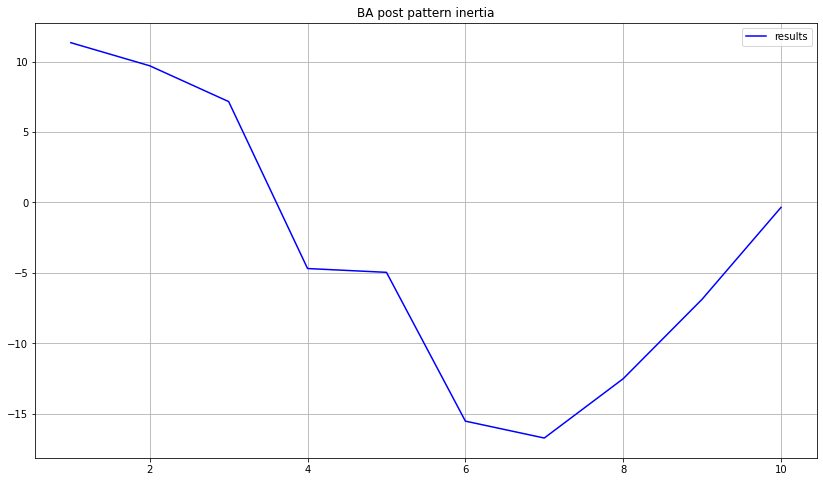


Pattern analysis on: CAT

Occurrences: 6 

DatetimeIndex(['2008-01-10', '2012-05-09', '2015-01-30', '2019-10-04',
               '2020-03-16', '2020-05-14'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 3.59 average of 0.6 with 3 winning trades and 3 loosing trades
After: 2 days: 12.73 average of 2.12 with 3 winning trades and 3 loosing trades
After: 3 days: 8.41 average of 1.4 with 3 winning trades and 3 loosing trades
After: 4 days: 7.33 average of 1.22 with 3 winning trades and 3 loosing trades
After: 5 days: 4.78 average of 0.8 with 3 winning trades and 3 loosing trades
After: 6 days: 10.4 average of 1.73 with 4 winning trades and 2 loosing trades
After: 7 days: 22.44 average of 3.74 with 4 winning trades and 2 loosing trades
After: 8 days: 36.51 average of 6.08 with 4 winning trades and 2 loosing trades
After: 9 days: 31.45 average of 5.24 with 4 winning trades and 2 loosing trades
After: 10 days: 39.01 average of 6.5 with 4 winning trades and 2 

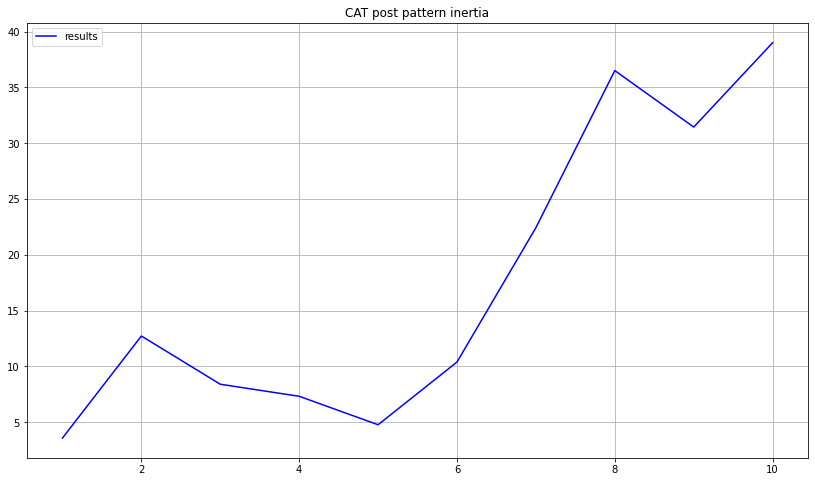


Pattern analysis on: CVX

Occurrences: 9 

DatetimeIndex(['2007-08-07', '2009-02-13', '2011-04-19', '2011-06-24',
               '2014-10-06', '2016-01-21', '2016-08-03', '2018-07-19',
               '2019-10-07'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.28 average of -0.03 with 5 winning trades and 4 loosing trades
After: 2 days: -1.9 average of -0.21 with 6 winning trades and 3 loosing trades
After: 3 days: 5.64 average of 0.63 with 5 winning trades and 4 loosing trades
After: 4 days: 7.23 average of 0.8 with 5 winning trades and 4 loosing trades
After: 5 days: 5.24 average of 0.58 with 5 winning trades and 4 loosing trades
After: 6 days: 8.47 average of 0.94 with 6 winning trades and 3 loosing trades
After: 7 days: 7.64 average of 0.85 with 6 winning trades and 3 loosing trades
After: 8 days: 7.56 average of 0.84 with 6 winning trades and 3 loosing trades
After: 9 days: 5.4 average of 0.6 with 6 winning trades and 3 loosing trades
After: 10

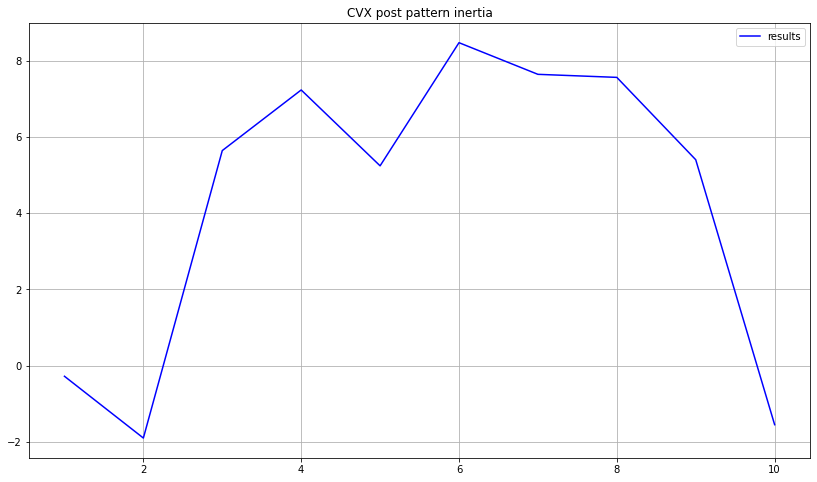


Pattern analysis on: CSCO

Occurrences: 3 

DatetimeIndex(['2009-07-14', '2013-02-15', '2018-04-04'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 1.26 average of 0.42 with 3 winning trades and 0 loosing trades
After: 2 days: 0.13 average of 0.04 with 2 winning trades and 1 loosing trades
After: 3 days: 0.61 average of 0.2 with 1 winning trades and 2 loosing trades
After: 4 days: 2.73 average of 0.91 with 2 winning trades and 1 loosing trades
After: 5 days: 2.85 average of 0.95 with 2 winning trades and 1 loosing trades
After: 6 days: 3.57 average of 1.19 with 2 winning trades and 1 loosing trades
After: 7 days: 3.96 average of 1.32 with 2 winning trades and 1 loosing trades
After: 8 days: 4.21 average of 1.4 with 2 winning trades and 1 loosing trades
After: 9 days: 5.43 average of 1.81 with 2 winning trades and 1 loosing trades
After: 10 days: 5.47 average of 1.82 with 2 winning trades and 1 loosing trades


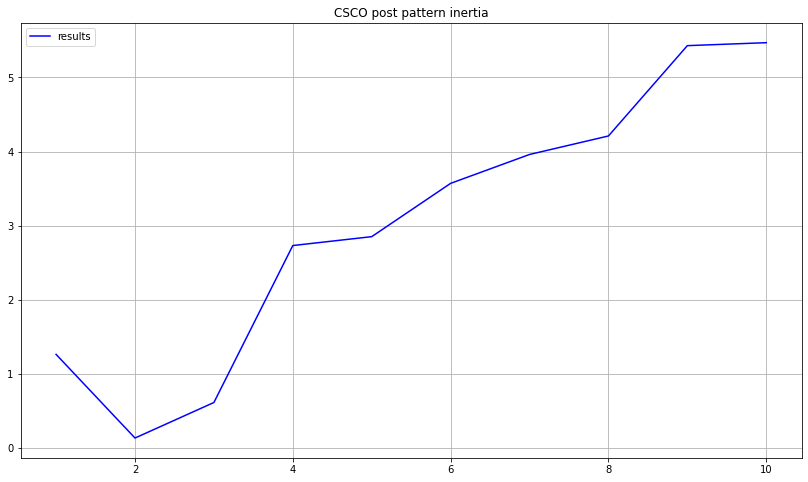


Pattern analysis on: KO

Occurrences: 3 

DatetimeIndex(['2013-05-24', '2013-07-29', '2017-12-12'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.3 average of 0.1 with 1 winning trades and 2 loosing trades
After: 2 days: -0.96 average of -0.32 with 1 winning trades and 2 loosing trades
After: 3 days: -0.94 average of -0.31 with 2 winning trades and 1 loosing trades
After: 4 days: -2.33 average of -0.78 with 1 winning trades and 2 loosing trades
After: 5 days: -1.24 average of -0.41 with 1 winning trades and 2 loosing trades
After: 6 days: -0.6 average of -0.2 with 1 winning trades and 2 loosing trades
After: 7 days: -2.07 average of -0.69 with 1 winning trades and 2 loosing trades
After: 8 days: -1.89 average of -0.63 with 1 winning trades and 2 loosing trades
After: 9 days: -1.09 average of -0.36 with 1 winning trades and 2 loosing trades
After: 10 days: -1.53 average of -0.51 with 1 winning trades and 2 loosing trades


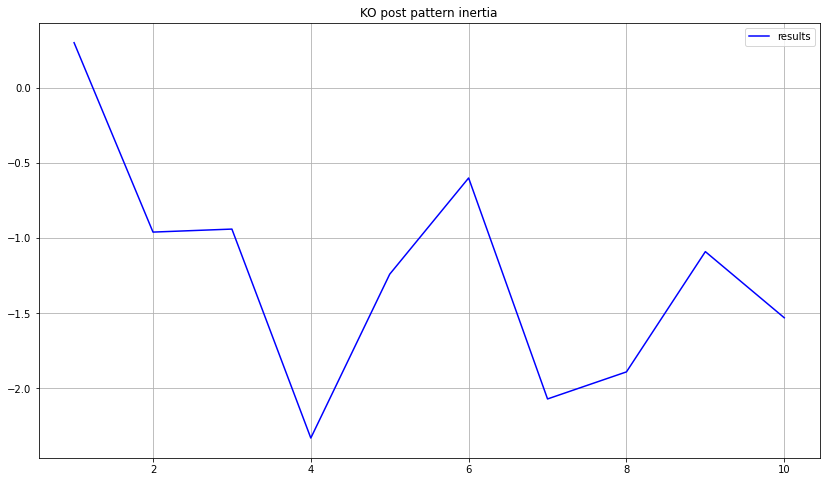


Pattern analysis on: XOM

Occurrences: 4 

DatetimeIndex(['2017-07-31', '2018-07-31', '2019-05-08', '2019-07-23'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.1 average of -0.02 with 2 winning trades and 2 loosing trades
After: 2 days: -0.79 average of -0.2 with 2 winning trades and 2 loosing trades
After: 3 days: -1.58 average of -0.4 with 1 winning trades and 3 loosing trades
After: 4 days: -1.25 average of -0.31 with 1 winning trades and 3 loosing trades
After: 5 days: 0.36 average of 0.09 with 2 winning trades and 2 loosing trades
After: 6 days: -1.38 average of -0.34 with 1 winning trades and 3 loosing trades
After: 7 days: -3.89 average of -0.97 with 1 winning trades and 3 loosing trades
After: 8 days: -6.75 average of -1.69 with 0 winning trades and 4 loosing trades
After: 9 days: -9.49 average of -2.37 with 0 winning trades and 4 loosing trades
After: 10 days: -9.73 average of -2.43 with 0 winning trades and 4 loosing trades


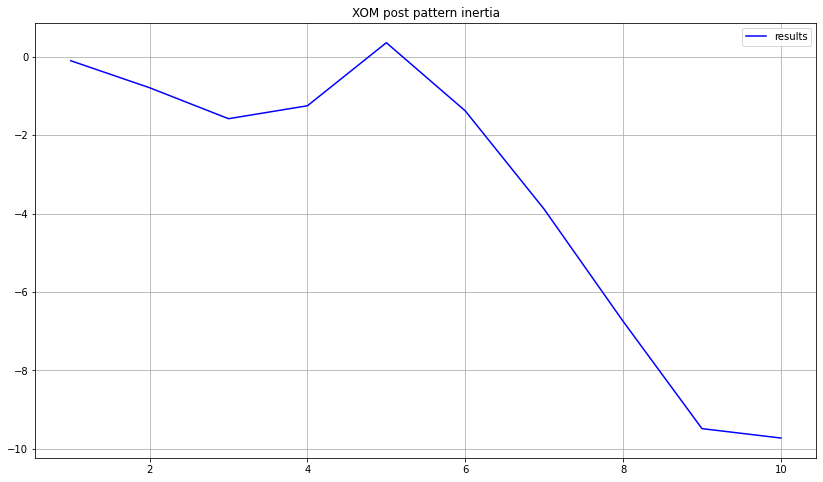


Pattern analysis on: GS

Occurrences: 8 

DatetimeIndex(['2008-10-29', '2016-02-04', '2016-09-29', '2018-02-12',
               '2018-05-04', '2019-03-08', '2019-05-24', '2019-05-30'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -11.21 average of -1.4 with 3 winning trades and 5 loosing trades
After: 2 days: -10.42 average of -1.3 with 3 winning trades and 5 loosing trades
After: 3 days: 2.83 average of 0.35 with 5 winning trades and 3 loosing trades
After: 4 days: 7.4 average of 0.92 with 5 winning trades and 3 loosing trades
After: 5 days: -6.35 average of -0.79 with 5 winning trades and 3 loosing trades
After: 6 days: 5.46 average of 0.68 with 5 winning trades and 3 loosing trades
After: 7 days: 3.82 average of 0.48 with 5 winning trades and 3 loosing trades
After: 8 days: -2.91 average of -0.36 with 4 winning trades and 4 loosing trades
After: 9 days: -4.01 average of -0.5 with 4 winning trades and 4 loosing trades
After: 10 days: -20.11 average 

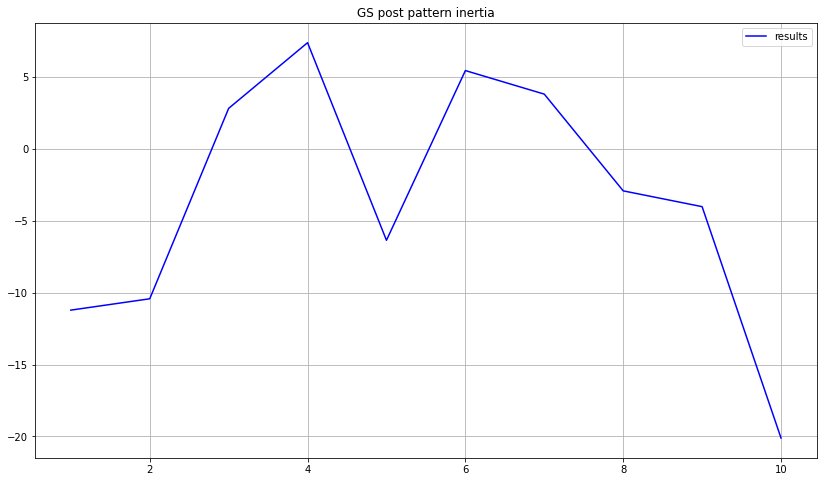


Pattern analysis on: HD

Occurrences: 6 

DatetimeIndex(['2007-03-15', '2007-09-26', '2008-01-10', '2008-10-17',
               '2016-10-20', '2020-09-22'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -8.14 average of -1.36 with 2 winning trades and 4 loosing trades
After: 2 days: -7.5 average of -1.25 with 4 winning trades and 2 loosing trades
After: 3 days: -9.23 average of -1.54 with 3 winning trades and 3 loosing trades
After: 4 days: -4.51 average of -0.75 with 3 winning trades and 3 loosing trades
After: 5 days: -5.72 average of -0.95 with 3 winning trades and 3 loosing trades
After: 6 days: 1.39 average of 0.23 with 4 winning trades and 2 loosing trades
After: 7 days: 4.48 average of 0.75 with 5 winning trades and 1 loosing trades
After: 8 days: 5.02 average of 0.84 with 4 winning trades and 2 loosing trades
After: 9 days: 8.19 average of 1.36 with 4 winning trades and 2 loosing trades
After: 10 days: 2.19 average of 0.36 with 4 winning trades

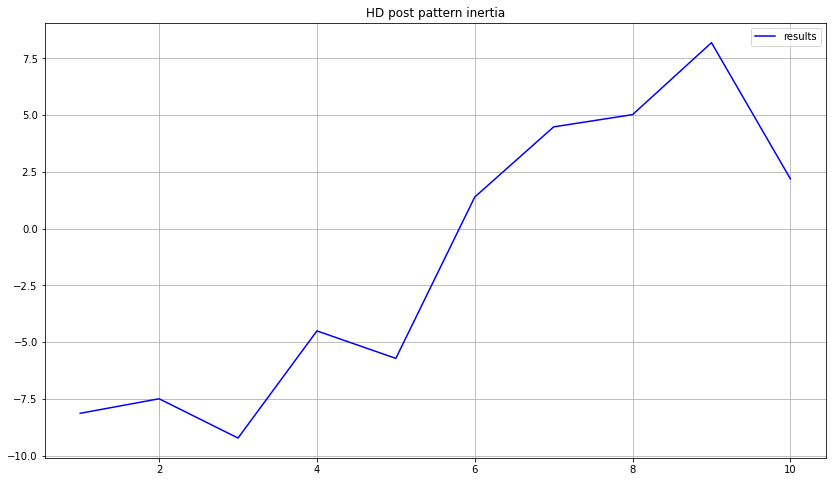


Pattern analysis on: IBM

Occurrences: 9 

DatetimeIndex(['2008-09-04', '2009-02-26', '2009-09-04', '2014-05-08',
               '2015-06-16', '2017-07-12', '2019-08-08', '2019-10-04',
               '2020-09-22'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -1.58 average of -0.18 with 4 winning trades and 5 loosing trades
After: 2 days: -3.47 average of -0.39 with 5 winning trades and 4 loosing trades
After: 3 days: -5.14 average of -0.57 with 2 winning trades and 7 loosing trades
After: 4 days: -2.08 average of -0.23 with 6 winning trades and 3 loosing trades
After: 5 days: -8.43 average of -0.94 with 5 winning trades and 4 loosing trades
After: 6 days: -8.93 average of -0.99 with 3 winning trades and 6 loosing trades
After: 7 days: -12.44 average of -1.38 with 4 winning trades and 5 loosing trades
After: 8 days: -15.02 average of -1.67 with 2 winning trades and 7 loosing trades
After: 9 days: -23.95 average of -2.66 with 3 winning trades and 6 loo

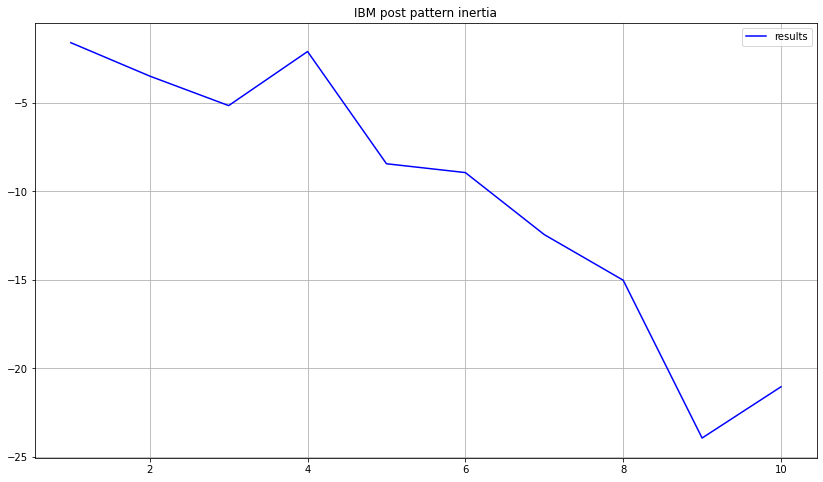


Pattern analysis on: INTC

Occurrences: 4 

DatetimeIndex(['2007-03-30', '2008-11-19', '2013-04-08', '2014-09-29'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.49 average of 0.12 with 1 winning trades and 3 loosing trades
After: 2 days: 1.23 average of 0.31 with 3 winning trades and 1 loosing trades
After: 3 days: 0.85 average of 0.21 with 3 winning trades and 1 loosing trades
After: 4 days: 0.98 average of 0.24 with 3 winning trades and 1 loosing trades
After: 5 days: 2.12 average of 0.53 with 3 winning trades and 1 loosing trades
After: 6 days: 2.43 average of 0.61 with 3 winning trades and 1 loosing trades
After: 7 days: 1.79 average of 0.45 with 3 winning trades and 1 loosing trades
After: 8 days: 2.2 average of 0.55 with 3 winning trades and 1 loosing trades
After: 9 days: 1.03 average of 0.26 with 3 winning trades and 1 loosing trades
After: 10 days: 0.37 average of 0.09 with 3 winning trades and 1 loosing trades


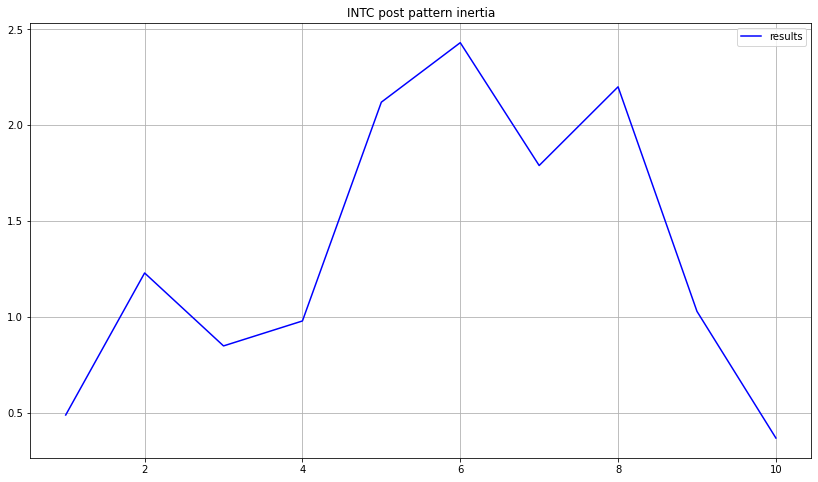


Pattern analysis on: JNJ

Occurrences: 5 

DatetimeIndex(['2017-07-28', '2018-07-03', '2019-05-16', '2019-09-30',
               '2020-03-25'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 9.56 average of 1.91 with 4 winning trades and 1 loosing trades
After: 2 days: 8.51 average of 1.7 with 5 winning trades and 0 loosing trades
After: 3 days: 17.2 average of 3.44 with 5 winning trades and 0 loosing trades
After: 4 days: 20.95 average of 4.19 with 5 winning trades and 0 loosing trades
After: 5 days: 17.85 average of 3.57 with 5 winning trades and 0 loosing trades
After: 6 days: 21.13 average of 4.23 with 5 winning trades and 0 loosing trades
After: 7 days: 15.33 average of 3.07 with 4 winning trades and 1 loosing trades
After: 8 days: 14.74 average of 2.95 with 3 winning trades and 2 loosing trades
After: 9 days: 19.79 average of 3.96 with 4 winning trades and 1 loosing trades
After: 10 days: 22.7 average of 4.54 with 4 winning trades and 1 loosing tr

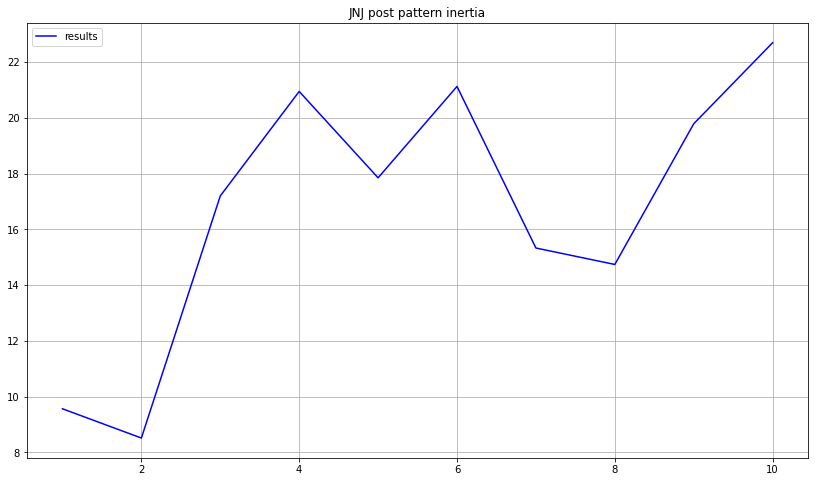


Pattern analysis on: JPM

Occurrences: 5 

DatetimeIndex(['2007-07-31', '2007-11-09', '2011-07-19', '2018-05-04',
               '2018-06-27'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 3.09 average of 0.62 with 5 winning trades and 0 loosing trades
After: 2 days: 8.18 average of 1.64 with 5 winning trades and 0 loosing trades
After: 3 days: 10.54 average of 2.11 with 4 winning trades and 1 loosing trades
After: 4 days: 9.29 average of 1.86 with 4 winning trades and 1 loosing trades
After: 5 days: 8.51 average of 1.7 with 5 winning trades and 0 loosing trades
After: 6 days: 7.57 average of 1.51 with 3 winning trades and 2 loosing trades
After: 7 days: 7.85 average of 1.57 with 3 winning trades and 2 loosing trades
After: 8 days: 6.4 average of 1.28 with 3 winning trades and 2 loosing trades
After: 9 days: 6.63 average of 1.33 with 3 winning trades and 2 loosing trades
After: 10 days: 2.64 average of 0.53 with 2 winning trades and 3 loosing trades


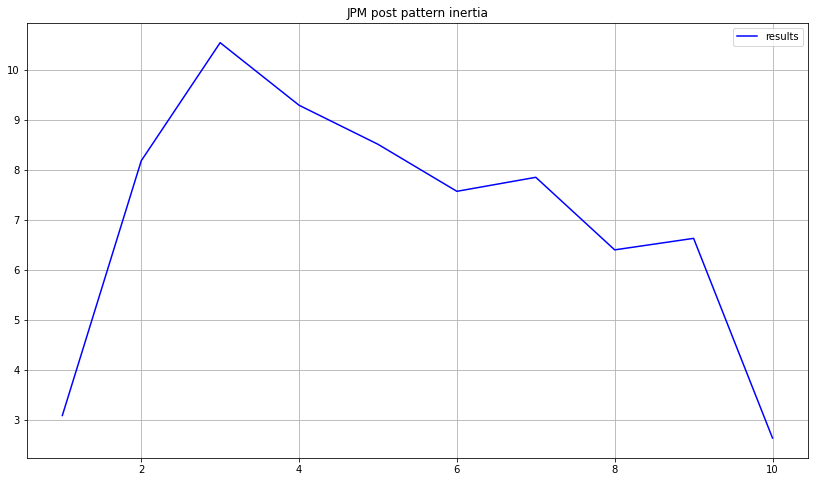


Pattern analysis on: MCD

Occurrences: 5 

DatetimeIndex(['2007-03-07', '2009-04-16', '2010-07-02', '2015-04-06',
               '2019-02-05'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -1.03 average of -0.21 with 2 winning trades and 3 loosing trades
After: 2 days: -0.48 average of -0.1 with 4 winning trades and 1 loosing trades
After: 3 days: 1.22 average of 0.24 with 4 winning trades and 1 loosing trades
After: 4 days: -0.39 average of -0.08 with 2 winning trades and 3 loosing trades
After: 5 days: 0.9 average of 0.18 with 3 winning trades and 2 loosing trades
After: 6 days: 0.95 average of 0.19 with 2 winning trades and 3 loosing trades
After: 7 days: 1.78 average of 0.36 with 2 winning trades and 3 loosing trades
After: 8 days: 5.93 average of 1.19 with 2 winning trades and 3 loosing trades
After: 9 days: 3.39 average of 0.68 with 3 winning trades and 2 loosing trades
After: 10 days: 5.08 average of 1.02 with 3 winning trades and 2 loosing tra

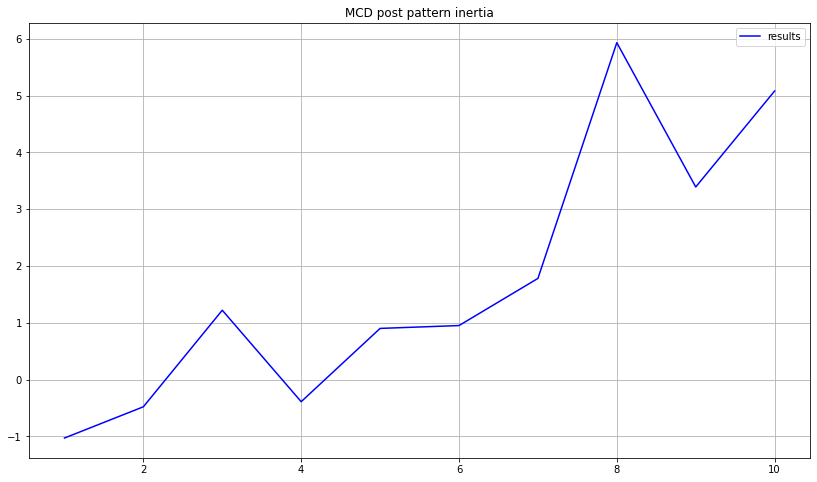


Pattern analysis on: MSFT

Occurrences: 8 

DatetimeIndex(['2008-11-19', '2010-02-02', '2011-02-15', '2011-02-17',
               '2014-05-08', '2015-07-08', '2016-02-09', '2016-10-13'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.43 average of -0.05 with 2 winning trades and 6 loosing trades
After: 2 days: 0.95 average of 0.12 with 4 winning trades and 4 loosing trades
After: 3 days: 4.62 average of 0.58 with 6 winning trades and 2 loosing trades
After: 4 days: 3.69 average of 0.46 with 5 winning trades and 3 loosing trades
After: 5 days: 4.81 average of 0.6 with 5 winning trades and 3 loosing trades
After: 6 days: 8.04 average of 1.0 with 5 winning trades and 3 loosing trades
After: 7 days: 6.77 average of 0.85 with 5 winning trades and 3 loosing trades
After: 8 days: 8.12 average of 1.01 with 5 winning trades and 3 loosing trades
After: 9 days: 8.16 average of 1.02 with 6 winning trades and 2 loosing trades
After: 10 days: 4.97 average of 0.62 

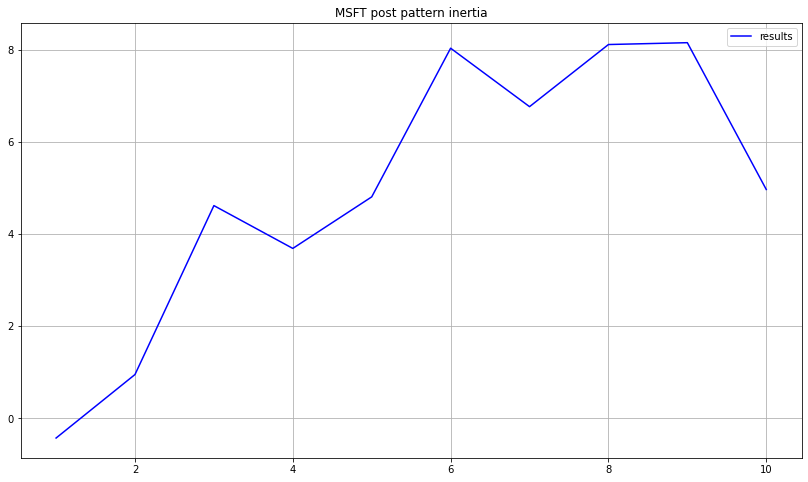


Pattern analysis on: NKE

Occurrences: 5 

DatetimeIndex(['2008-03-12', '2012-06-05', '2012-06-19', '2014-06-16',
               '2015-08-13'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 1.01 average of 0.2 with 4 winning trades and 1 loosing trades
After: 2 days: 1.05 average of 0.21 with 4 winning trades and 1 loosing trades
After: 3 days: 1.01 average of 0.2 with 4 winning trades and 1 loosing trades
After: 4 days: 0.63 average of 0.13 with 4 winning trades and 1 loosing trades
After: 5 days: -0.2 average of -0.04 with 3 winning trades and 2 loosing trades
After: 6 days: -3.2 average of -0.64 with 2 winning trades and 3 loosing trades
After: 7 days: -4.37 average of -0.87 with 2 winning trades and 3 loosing trades
After: 8 days: -6.38 average of -1.28 with 2 winning trades and 3 loosing trades
After: 9 days: -3.69 average of -0.74 with 2 winning trades and 3 loosing trades
After: 10 days: -1.44 average of -0.29 with 2 winning trades and 3 loosing

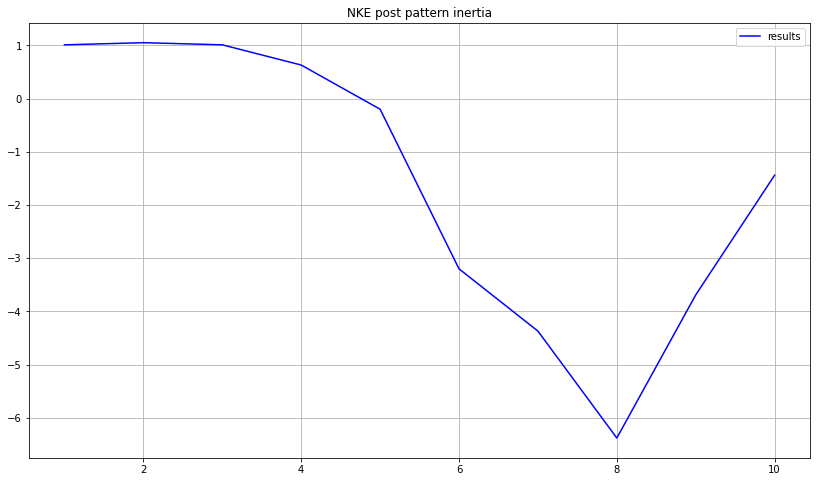


Basket analysis:
Positive inertia after 1 bars: ['MMM', 'BA', 'CAT', 'CSCO', 'KO', 'INTC', 'JNJ', 'JPM', 'NKE']
Positive inertia after 2 bars: ['MMM', 'BA', 'CAT', 'CSCO', 'INTC', 'JNJ', 'JPM', 'MSFT', 'NKE']
Positive inertia after 3 bars: ['MMM', 'BA', 'CAT', 'CVX', 'CSCO', 'GS', 'INTC', 'JNJ', 'JPM', 'MCD', 'MSFT', 'NKE']
Positive inertia after 4 bars: ['MMM', 'AAPL', 'CAT', 'CVX', 'CSCO', 'GS', 'INTC', 'JNJ', 'JPM', 'MSFT', 'NKE']
Positive inertia after 5 bars: ['MMM', 'AAPL', 'CAT', 'CVX', 'CSCO', 'XOM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MSFT']
Positive inertia after 6 bars: ['MMM', 'AAPL', 'CAT', 'CVX', 'CSCO', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'MCD', 'MSFT']
Positive inertia after 7 bars: ['MMM', 'CAT', 'CVX', 'CSCO', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'MCD', 'MSFT']
Positive inertia after 8 bars: ['MMM', 'CAT', 'CVX', 'CSCO', 'HD', 'INTC', 'JNJ', 'JPM', 'MCD', 'MSFT']
Positive inertia after 9 bars: ['MMM', 'CAT', 'CVX', 'CSCO', 'HD', 'INTC', 'JNJ', 'JPM', 'MCD', 'MSFT']
Positive ine

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MSFT,NKE,basket
1,4.18,-1.96,-1.12,11.34,3.59,-0.28,1.26,0.30,-0.10,-11.21,-8.14,-1.58,0.49,9.56,3.09,-1.03,-0.43,1.01,0.498333
2,5.76,-2.94,-0.34,9.70,12.73,-1.90,0.13,-0.96,-0.79,-10.42,-7.50,-3.47,1.23,8.51,8.18,-0.48,0.95,1.05,1.080000
3,9.24,-5.57,-0.25,7.16,8.41,5.64,0.61,-0.94,-1.58,2.83,-9.23,-5.14,0.85,17.20,10.54,1.22,4.62,1.01,2.590000
4,6.56,-4.28,0.55,-4.69,7.33,7.23,2.73,-2.33,-1.25,7.40,-4.51,-2.08,0.98,20.95,9.29,-0.39,3.69,0.63,2.656111
5,4.97,-7.14,0.84,-4.96,4.78,5.24,2.85,-1.24,0.36,-6.35,-5.72,-8.43,2.12,17.85,8.51,0.90,4.81,-0.20,1.066111
6,11.08,-4.87,0.15,-15.52,10.40,8.47,3.57,-0.60,-1.38,5.46,1.39,-8.93,2.43,21.13,7.57,0.95,8.04,-3.20,2.563333
7,18.67,-6.77,-0.12,-16.72,22.44,7.64,3.96,-2.07,-3.89,3.82,4.48,-12.44,1.79,15.33,7.85,1.78,6.77,-4.37,2.675000
8,18.20,-3.88,0.00,-12.51,36.51,7.56,4.21,-1.89,-6.75,-2.91,5.02,-15.02,2.20,14.74,6.40,5.93,8.12,-6.38,3.308333
9,16.51,-5.99,-0.69,-6.87,31.45,5.40,5.43,-1.09,-9.49,-4.01,8.19,-23.95,1.03,19.79,6.63,3.39,8.16,-3.69,2.788889
10,16.69,-3.90,-0.73,-0.35,39.01,-1.55,5.47,-1.53,-9.73,-20.11,2.19,-21.05,0.37,22.70,2.64,5.08,4.97,-1.44,2.151667


In [7]:
basket_results = pd.DataFrame(index = range(1, days_after + 1))

for ticker in tickerlist.split(","):

    print("Pattern analysis on: " + ticker + "\n")

    dataset = create_asset_dataset(matrix)
    
    pattern = (dataset.low.shift(1) < dataset.BBL.shift(1)) & (dataset.close.shift(1) > dataset.BBL.shift(1)) &\
              (dataset.close_pos.shift(1) > 70) & (dataset.open_pos.shift(1) > 70) &\
              (dataset.range_perc.shift(1) > 1) &\
              (dataset.high > dataset.high.shift(1)) & (dataset.open <= dataset.high.shift(1))
    
    results = pattern_stats(dataset, pattern, "long", days_after, ticker)
    
    if show_patterns == True:
        plot_patterns(dataset,results[0],3,days_after)
        
    basket_results[ticker] = results[1]
        
    print("")
    
print("Basket analysis:")
positive_effect(basket_results)
    
basket_results["basket"] = basket_results.mean(axis = 1)
basket_results

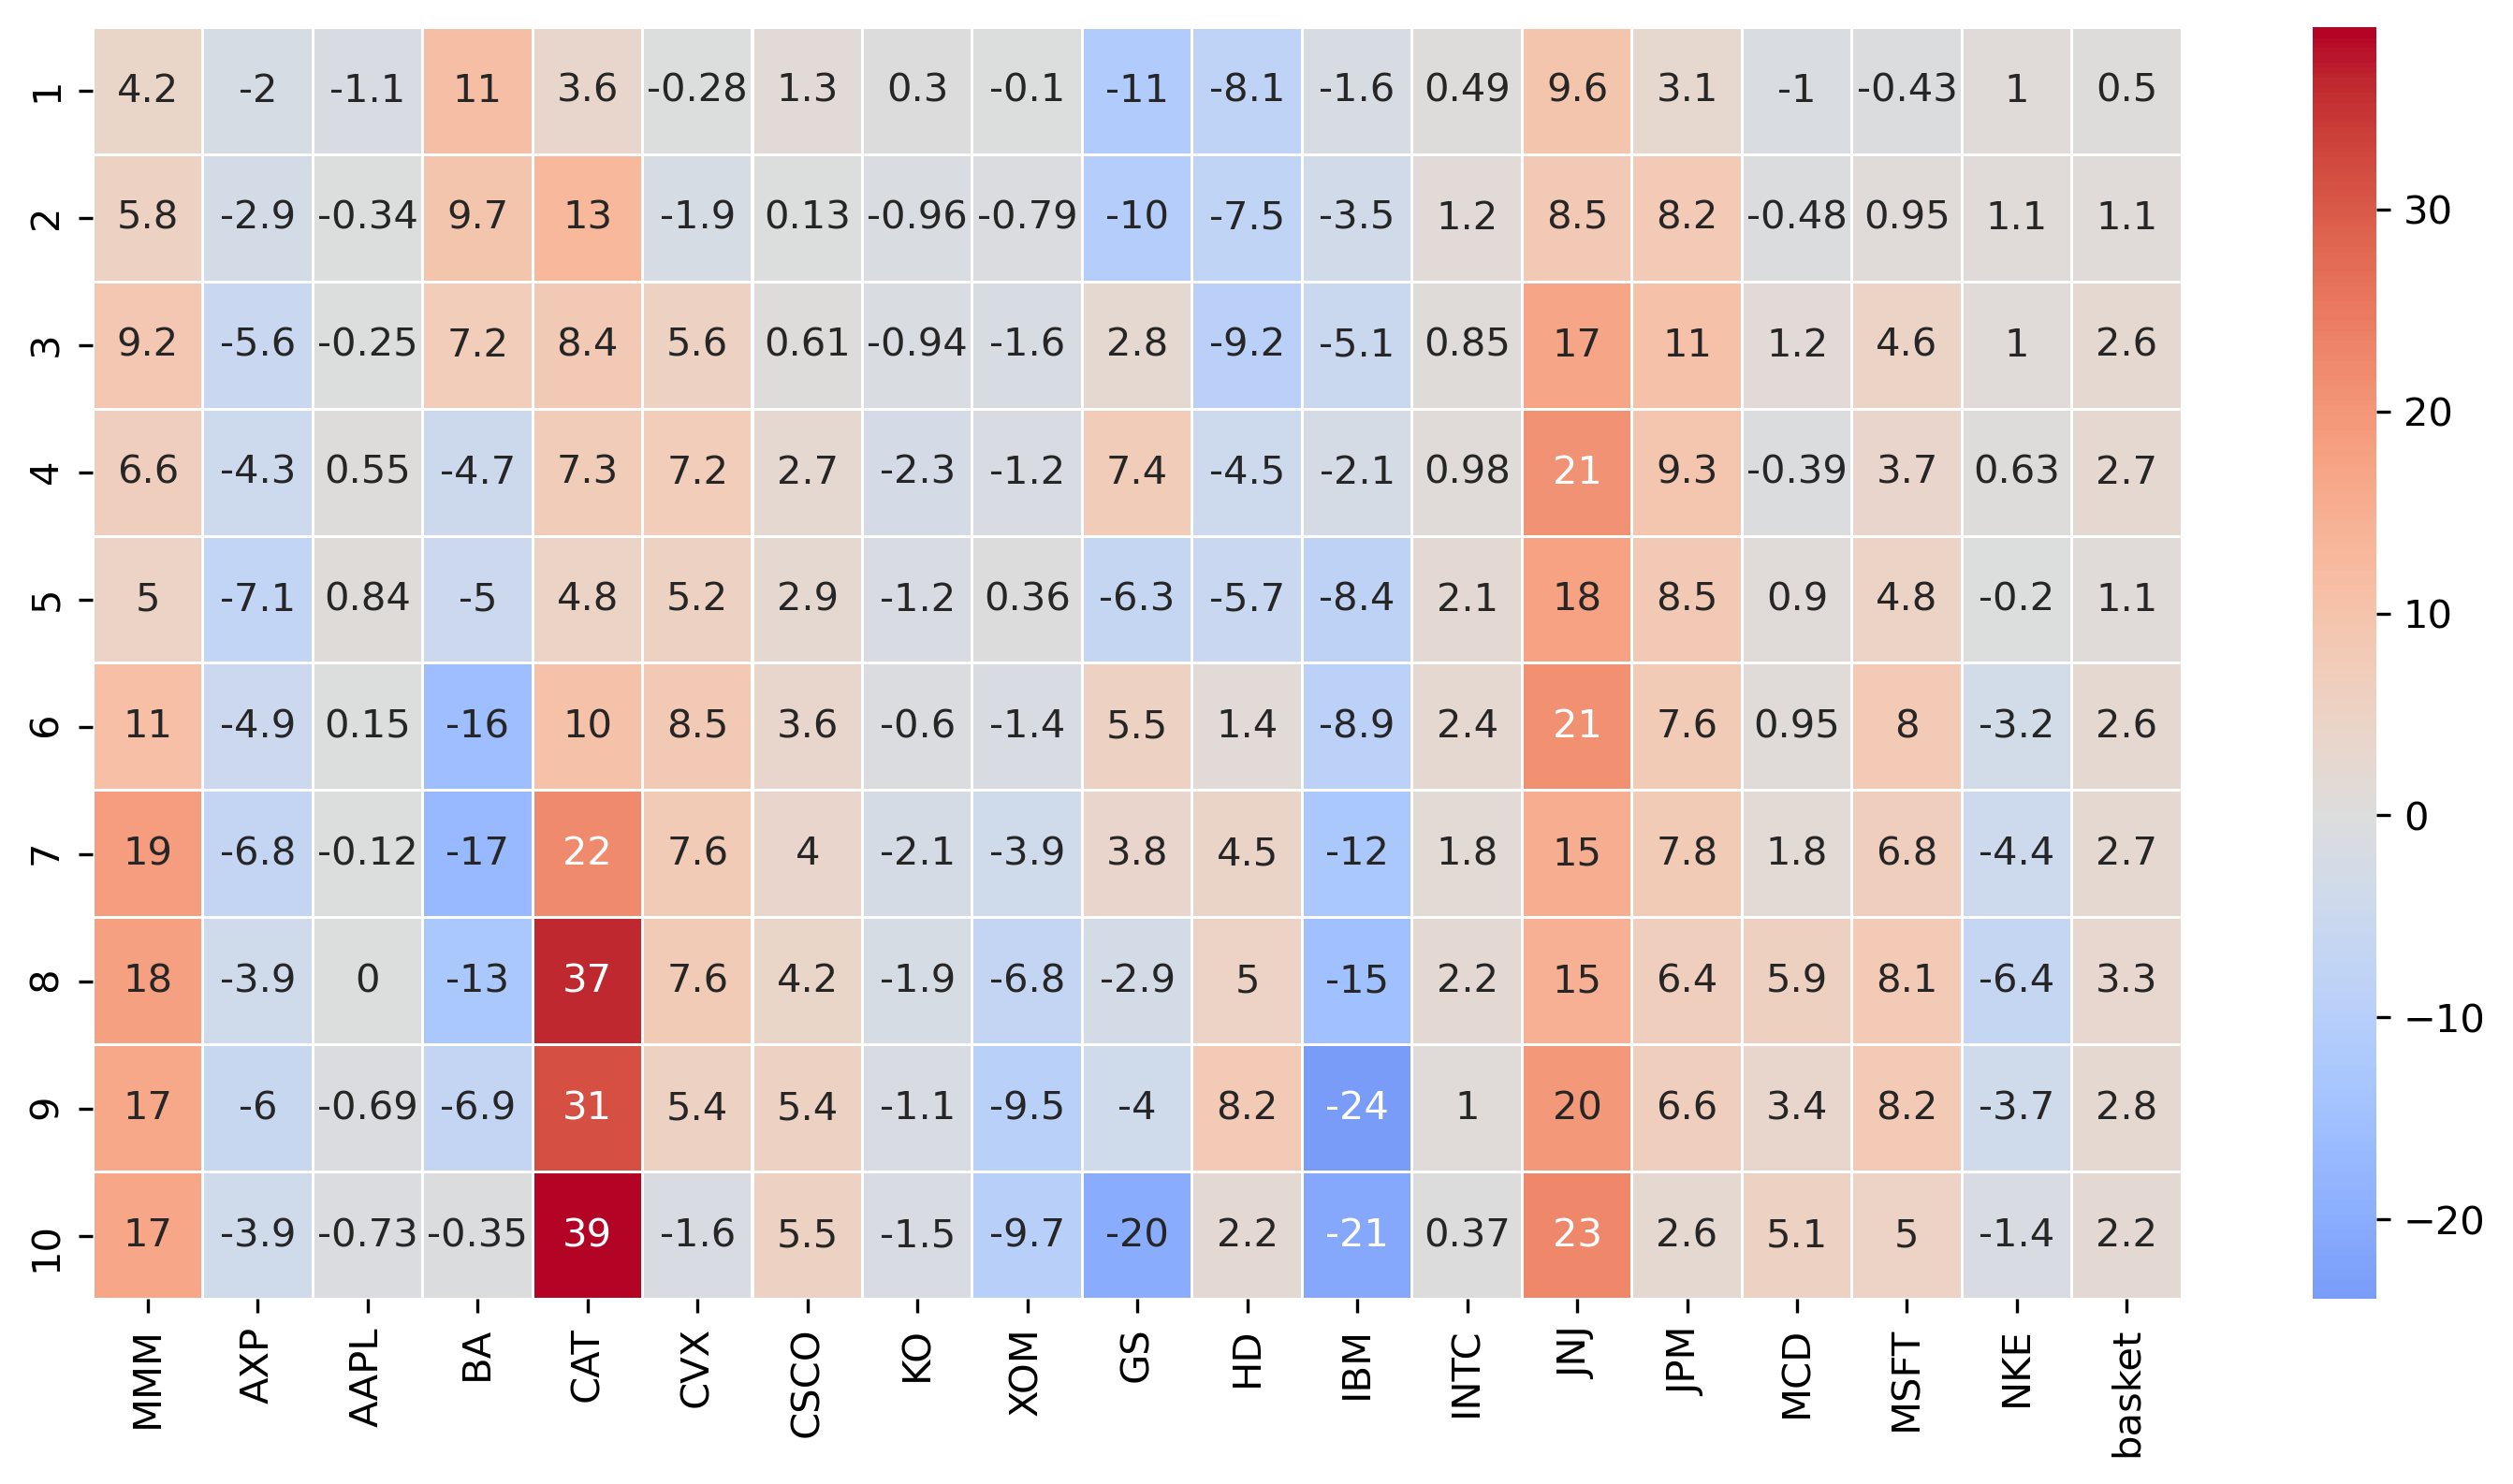

In [8]:
import seaborn as sns
plt.figure(figsize = [12,6], dpi = 300)
plt.xticks(rotation = 90)
ax = sns.heatmap(basket_results, annot=True, cmap="coolwarm", center = 0, linewidths=.5)

In [9]:
basket_results.iplot(title = "Pattern inertia")

# <span style="color:red">Esempio "Shooting Star" con conferma</span>

Pattern analysis on: MMM

Occurrences: 3 

DatetimeIndex(['2009-11-12', '2011-01-28', '2013-12-23'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.15 average of 0.05 with 2 winning trades and 1 loosing trades
After: 2 days: -1.72 average of -0.57 with 1 winning trades and 2 loosing trades
After: 3 days: -3.5 average of -1.17 with 1 winning trades and 2 loosing trades
After: 4 days: -2.79 average of -0.93 with 0 winning trades and 3 loosing trades
After: 5 days: -3.41 average of -1.14 with 0 winning trades and 3 loosing trades
After: 6 days: -1.18 average of -0.39 with 1 winning trades and 2 loosing trades
After: 7 days: -3.27 average of -1.09 with 0 winning trades and 3 loosing trades
After: 8 days: -3.64 average of -1.21 with 0 winning trades and 3 loosing trades
After: 9 days: -3.64 average of -1.21 with 0 winning trades and 3 loosing trades
After: 10 days: -2.8 average of -0.93 with 2 winning trades and 1 loosing trades


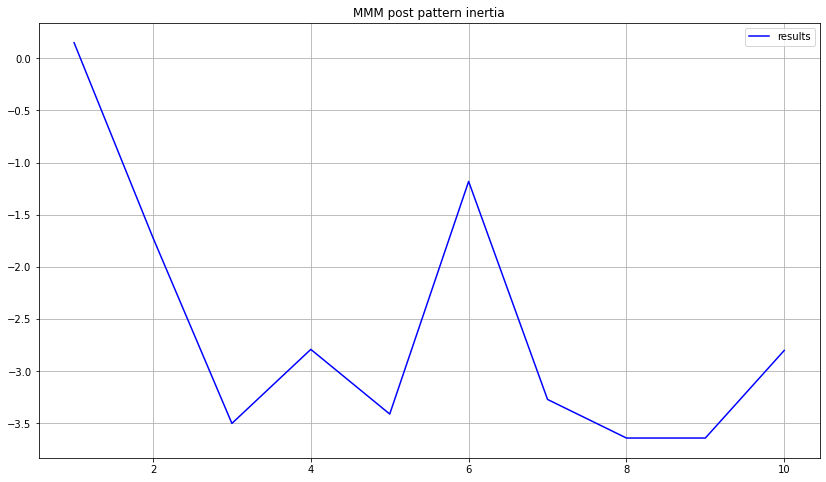


Pattern analysis on: AXP

Occurrences: 2 

DatetimeIndex(['2010-03-26', '2019-07-11'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.62 average of -0.31 with 0 winning trades and 2 loosing trades
After: 2 days: -1.04 average of -0.52 with 0 winning trades and 2 loosing trades
After: 3 days: -0.5 average of -0.25 with 1 winning trades and 1 loosing trades
After: 4 days: 0.04 average of 0.02 with 1 winning trades and 1 loosing trades
After: 5 days: -2.25 average of -1.12 with 0 winning trades and 2 loosing trades
After: 6 days: 0.88 average of 0.44 with 1 winning trades and 1 loosing trades
After: 7 days: 0.45 average of 0.22 with 1 winning trades and 1 loosing trades
After: 8 days: -3.07 average of -1.54 with 0 winning trades and 2 loosing trades
After: 9 days: -3.01 average of -1.5 with 0 winning trades and 2 loosing trades
After: 10 days: -2.87 average of -1.44 with 1 winning trades and 1 loosing trades


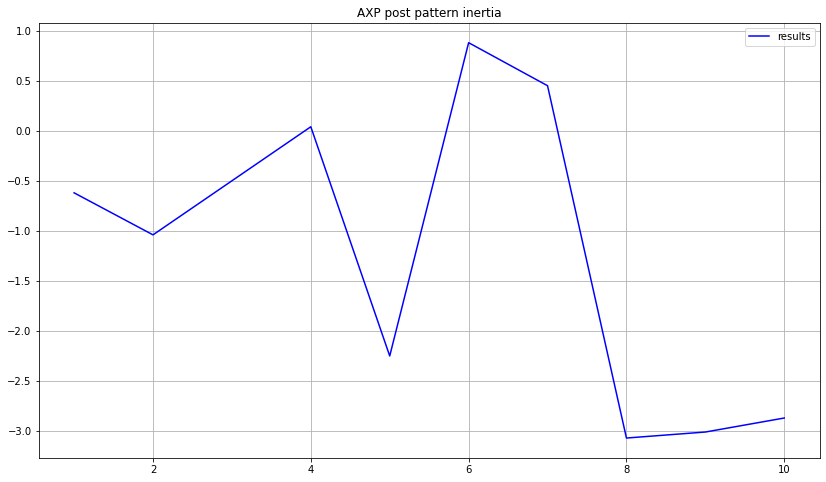


Pattern analysis on: AAPL

Occurrences: 7 

DatetimeIndex(['2007-02-26', '2007-05-01', '2007-12-28', '2009-03-25',
               '2009-09-24', '2018-05-08', '2019-10-08'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.18 average of -0.03 with 2 winning trades and 5 loosing trades
After: 2 days: -1.56 average of -0.22 with 3 winning trades and 4 loosing trades
After: 3 days: -2.71 average of -0.39 with 2 winning trades and 5 loosing trades
After: 4 days: -2.06 average of -0.29 with 3 winning trades and 4 loosing trades
After: 5 days: -1.44 average of -0.21 with 3 winning trades and 4 loosing trades
After: 6 days: -1.84 average of -0.26 with 1 winning trades and 6 loosing trades
After: 7 days: -2.21 average of -0.32 with 1 winning trades and 6 loosing trades
After: 8 days: -2.57 average of -0.37 with 2 winning trades and 5 loosing trades
After: 9 days: -3.65 average of -0.52 with 1 winning trades and 6 loosing trades
After: 10 days: -3.62 average of 

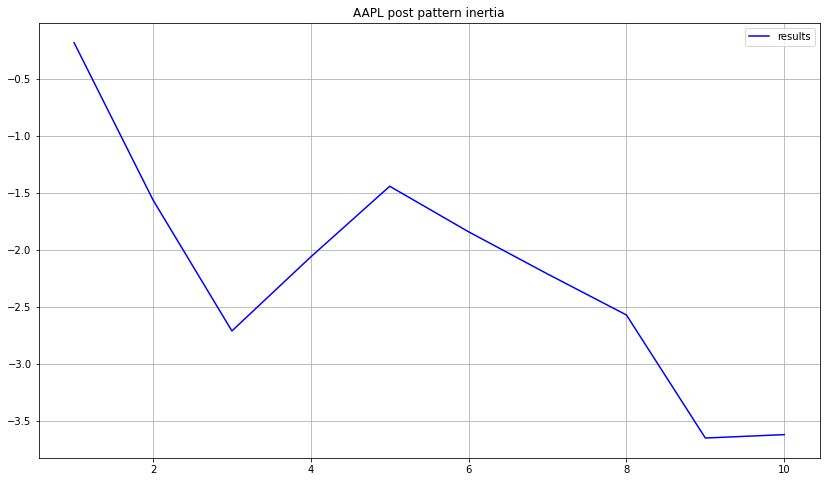


Pattern analysis on: BA

Occurrences: 5 

DatetimeIndex(['2017-06-21', '2017-07-13', '2017-09-25', '2018-02-28',
               '2018-05-11'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 11.05 average of 2.21 with 2 winning trades and 3 loosing trades
After: 2 days: 13.68 average of 2.74 with 2 winning trades and 3 loosing trades
After: 3 days: 10.77 average of 2.15 with 3 winning trades and 2 loosing trades
After: 4 days: 9.94 average of 1.99 with 3 winning trades and 2 loosing trades
After: 5 days: 2.82 average of 0.56 with 1 winning trades and 4 loosing trades
After: 6 days: -10.73 average of -2.15 with 2 winning trades and 3 loosing trades
After: 7 days: -8.25 average of -1.65 with 2 winning trades and 3 loosing trades
After: 8 days: -6.36 average of -1.27 with 2 winning trades and 3 loosing trades
After: 9 days: -24.53 average of -4.91 with 1 winning trades and 4 loosing trades
After: 10 days: -24.24 average of -4.85 with 1 winning trades and 4 

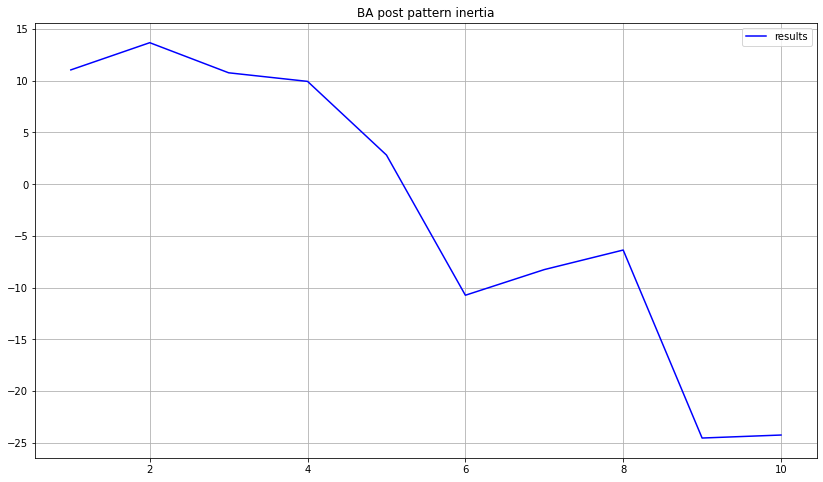


Pattern analysis on: CAT

Occurrences: 13 

DatetimeIndex(['2007-05-16', '2007-05-24', '2008-05-20', '2008-05-22',
               '2009-04-15', '2010-12-08', '2011-03-29', '2013-08-14',
               '2014-01-17', '2016-10-04', '2017-07-13', '2017-08-28',
               '2018-05-22'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -4.87 average of -0.37 with 6 winning trades and 7 loosing trades
After: 2 days: -3.51 average of -0.27 with 7 winning trades and 6 loosing trades
After: 3 days: -1.92 average of -0.15 with 6 winning trades and 7 loosing trades
After: 4 days: -0.74 average of -0.06 with 6 winning trades and 7 loosing trades
After: 5 days: -7.72 average of -0.59 with 6 winning trades and 7 loosing trades
After: 6 days: -2.24 average of -0.17 with 7 winning trades and 6 loosing trades
After: 7 days: -3.5 average of -0.27 with 7 winning trades and 6 loosing trades
After: 8 days: -12.08 average of -0.93 with 5 winning trades and 8 loosing trades


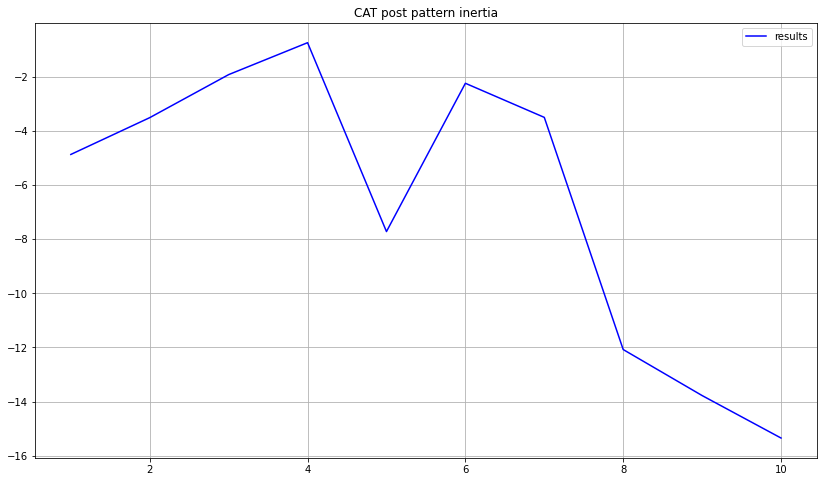


Pattern analysis on: CVX

Occurrences: 5 

DatetimeIndex(['2008-05-22', '2012-08-01', '2012-12-13', '2017-09-15',
               '2018-12-04'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.05 average of 0.01 with 2 winning trades and 3 loosing trades
After: 2 days: -2.26 average of -0.45 with 1 winning trades and 4 loosing trades
After: 3 days: -4.19 average of -0.84 with 2 winning trades and 3 loosing trades
After: 4 days: -3.71 average of -0.74 with 1 winning trades and 4 loosing trades
After: 5 days: -5.63 average of -1.13 with 1 winning trades and 4 loosing trades
After: 6 days: -6.69 average of -1.34 with 1 winning trades and 4 loosing trades
After: 7 days: -2.44 average of -0.49 with 2 winning trades and 3 loosing trades
After: 8 days: 1.27 average of 0.25 with 2 winning trades and 3 loosing trades
After: 9 days: -0.24 average of -0.05 with 2 winning trades and 3 loosing trades
After: 10 days: 5.1 average of 1.02 with 3 winning trades and 2 lo

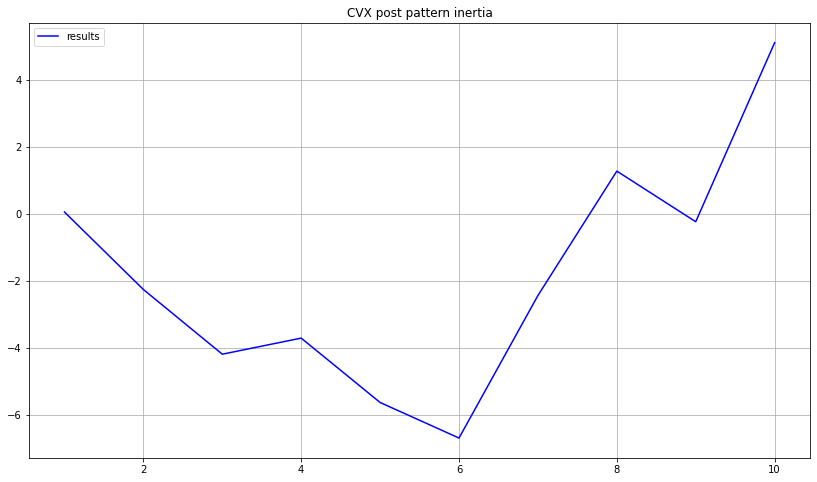


Pattern analysis on: CSCO

Occurrences: 7 

DatetimeIndex(['2007-03-29', '2007-10-02', '2010-07-30', '2014-04-04',
               '2014-12-26', '2018-01-25', '2018-09-28'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.66 average of -0.09 with 2 winning trades and 5 loosing trades
After: 2 days: -0.67 average of -0.1 with 2 winning trades and 5 loosing trades
After: 3 days: -1.11 average of -0.16 with 2 winning trades and 5 loosing trades
After: 4 days: 0.7 average of 0.1 with 4 winning trades and 3 loosing trades
After: 5 days: 1.3 average of 0.19 with 4 winning trades and 3 loosing trades
After: 6 days: 1.27 average of 0.18 with 3 winning trades and 4 loosing trades
After: 7 days: 4.3 average of 0.61 with 4 winning trades and 3 loosing trades
After: 8 days: 5.08 average of 0.73 with 3 winning trades and 4 loosing trades
After: 9 days: 8.28 average of 1.18 with 5 winning trades and 2 loosing trades
After: 10 days: 7.6 average of 1.09 with 5 winning

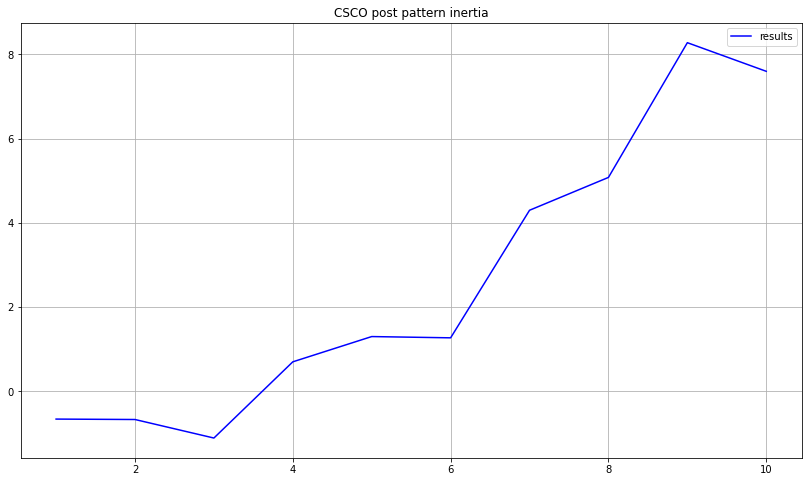


Pattern analysis on: KO

Occurrences: 5 

DatetimeIndex(['2008-03-28', '2013-11-26', '2014-04-11', '2020-07-16',
               '2020-07-29'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.52 average of -0.1 with 0 winning trades and 5 loosing trades
After: 2 days: -1.11 average of -0.22 with 2 winning trades and 3 loosing trades
After: 3 days: -1.06 average of -0.21 with 3 winning trades and 2 loosing trades
After: 4 days: -3.18 average of -0.64 with 2 winning trades and 3 loosing trades
After: 5 days: -3.4 average of -0.68 with 2 winning trades and 3 loosing trades
After: 6 days: -3.35 average of -0.67 with 3 winning trades and 2 loosing trades
After: 7 days: -4.38 average of -0.88 with 1 winning trades and 4 loosing trades
After: 8 days: -4.05 average of -0.81 with 1 winning trades and 4 loosing trades
After: 9 days: -4.14 average of -0.83 with 1 winning trades and 4 loosing trades
After: 10 days: -4.09 average of -0.82 with 1 winning trades and 

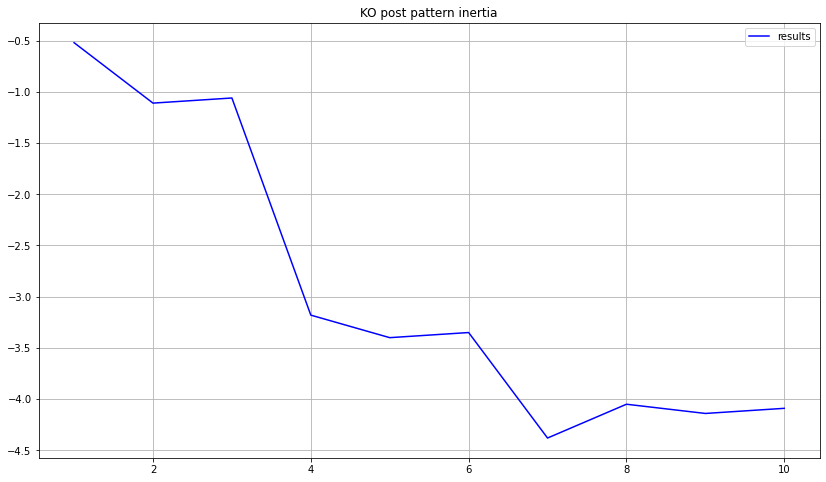


Pattern analysis on: XOM

Occurrences: 3 

DatetimeIndex(['2010-04-30', '2013-11-01', '2015-04-21'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -2.25 average of -0.75 with 1 winning trades and 2 loosing trades
After: 2 days: -0.85 average of -0.28 with 1 winning trades and 2 loosing trades
After: 3 days: -1.21 average of -0.4 with 2 winning trades and 1 loosing trades
After: 4 days: 2.29 average of 0.76 with 2 winning trades and 1 loosing trades
After: 5 days: 0.92 average of 0.31 with 1 winning trades and 2 loosing trades
After: 6 days: -0.91 average of -0.3 with 1 winning trades and 2 loosing trades
After: 7 days: 0.65 average of 0.22 with 1 winning trades and 2 loosing trades
After: 8 days: -1.2 average of -0.4 with 1 winning trades and 2 loosing trades
After: 9 days: -1.92 average of -0.64 with 1 winning trades and 2 loosing trades
After: 10 days: -2.33 average of -0.78 with 1 winning trades and 2 loosing trades


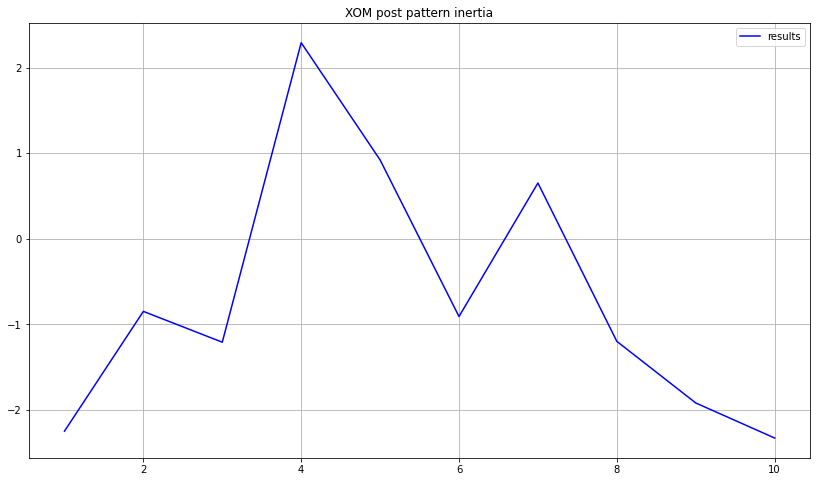


Pattern analysis on: GS

Occurrences: 4 

DatetimeIndex(['2009-03-25', '2011-04-08', '2011-10-20', '2020-07-17'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -2.25 average of -0.56 with 1 winning trades and 3 loosing trades
After: 2 days: 0.51 average of 0.13 with 2 winning trades and 2 loosing trades
After: 3 days: 17.94 average of 4.49 with 4 winning trades and 0 loosing trades
After: 4 days: 13.85 average of 3.46 with 3 winning trades and 1 loosing trades
After: 5 days: 1.72 average of 0.43 with 3 winning trades and 1 loosing trades
After: 6 days: -1.87 average of -0.47 with 2 winning trades and 2 loosing trades
After: 7 days: 2.58 average of 0.64 with 2 winning trades and 2 loosing trades
After: 8 days: 9.54 average of 2.38 with 2 winning trades and 2 loosing trades
After: 9 days: 9.76 average of 2.44 with 2 winning trades and 2 loosing trades
After: 10 days: 12.43 average of 3.11 with 2 winning trades and 2 loosing trades


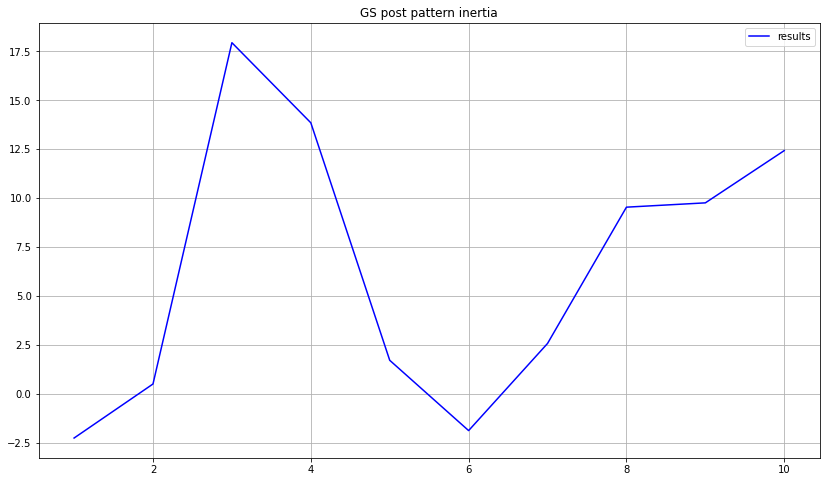


Pattern analysis on: HD

Occurrences: 9 

DatetimeIndex(['2010-11-17', '2011-05-18', '2011-07-22', '2011-11-17',
               '2014-12-15', '2015-01-02', '2015-01-29', '2017-03-27',
               '2019-03-25'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 7.07 average of 0.79 with 7 winning trades and 2 loosing trades
After: 2 days: 6.81 average of 0.76 with 7 winning trades and 2 loosing trades
After: 3 days: -0.83 average of -0.09 with 5 winning trades and 4 loosing trades
After: 4 days: -5.77 average of -0.64 with 5 winning trades and 4 loosing trades
After: 5 days: -9.69 average of -1.08 with 4 winning trades and 5 loosing trades
After: 6 days: -7.47 average of -0.83 with 4 winning trades and 5 loosing trades
After: 7 days: -10.21 average of -1.13 with 4 winning trades and 5 loosing trades
After: 8 days: -14.27 average of -1.59 with 5 winning trades and 4 loosing trades
After: 9 days: -13.95 average of -1.55 with 4 winning trades and 5 loosing 

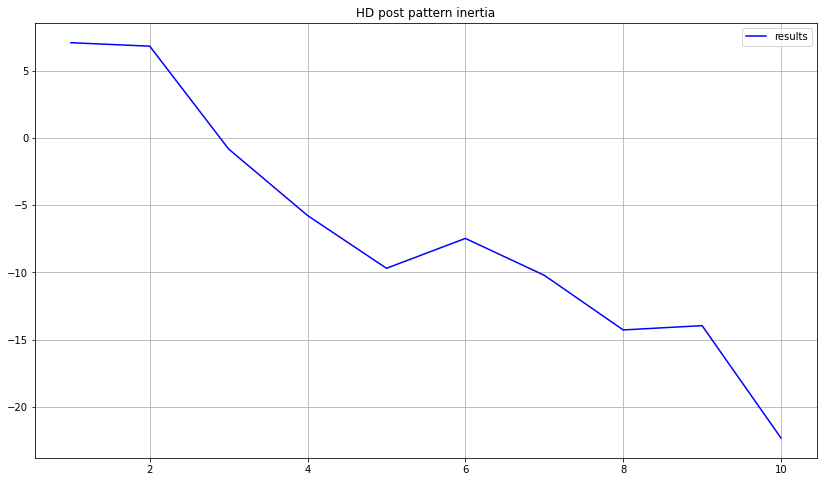


Pattern analysis on: IBM

Occurrences: 6 

DatetimeIndex(['2011-09-29', '2011-12-06', '2013-06-03', '2016-12-16',
               '2018-03-19', '2018-06-08'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 3.0 average of 0.5 with 5 winning trades and 1 loosing trades
After: 2 days: 8.8 average of 1.47 with 4 winning trades and 2 loosing trades
After: 3 days: 8.7 average of 1.45 with 4 winning trades and 2 loosing trades
After: 4 days: 11.04 average of 1.84 with 3 winning trades and 3 loosing trades
After: 5 days: 4.24 average of 0.71 with 5 winning trades and 1 loosing trades
After: 6 days: 8.95 average of 1.49 with 4 winning trades and 2 loosing trades
After: 7 days: 9.66 average of 1.61 with 5 winning trades and 1 loosing trades
After: 8 days: 12.57 average of 2.1 with 5 winning trades and 1 loosing trades
After: 9 days: 19.05 average of 3.18 with 5 winning trades and 1 loosing trades
After: 10 days: 12.15 average of 2.02 with 4 winning trades and 2 lo

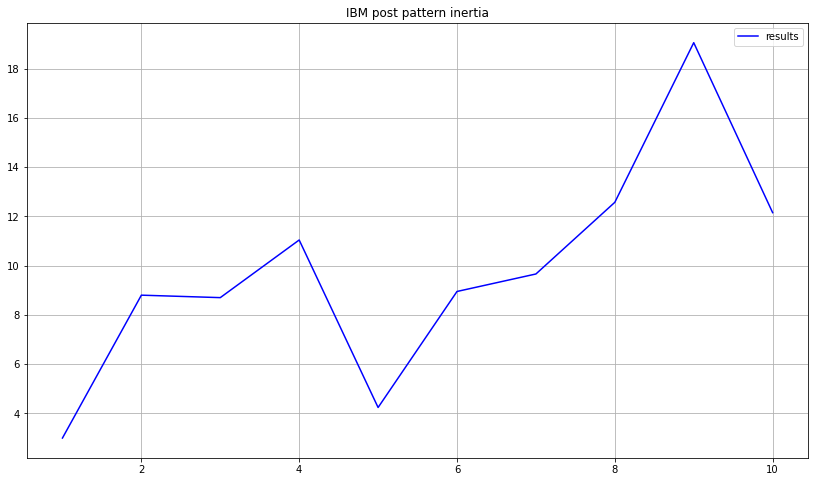


Pattern analysis on: INTC

Occurrences: 5 

DatetimeIndex(['2007-06-20', '2010-10-12', '2013-05-31', '2017-04-04',
               '2019-10-14'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.55 average of -0.11 with 2 winning trades and 3 loosing trades
After: 2 days: 0.23 average of 0.05 with 3 winning trades and 2 loosing trades
After: 3 days: 1.7 average of 0.34 with 5 winning trades and 0 loosing trades
After: 4 days: 2.71 average of 0.54 with 5 winning trades and 0 loosing trades
After: 5 days: 1.63 average of 0.33 with 4 winning trades and 1 loosing trades
After: 6 days: 0.88 average of 0.18 with 2 winning trades and 3 loosing trades
After: 7 days: 1.91 average of 0.38 with 5 winning trades and 0 loosing trades
After: 8 days: 0.81 average of 0.16 with 3 winning trades and 2 loosing trades
After: 9 days: -4.59 average of -0.92 with 2 winning trades and 3 loosing trades
After: 10 days: -5.14 average of -1.03 with 1 winning trades and 4 loosing t

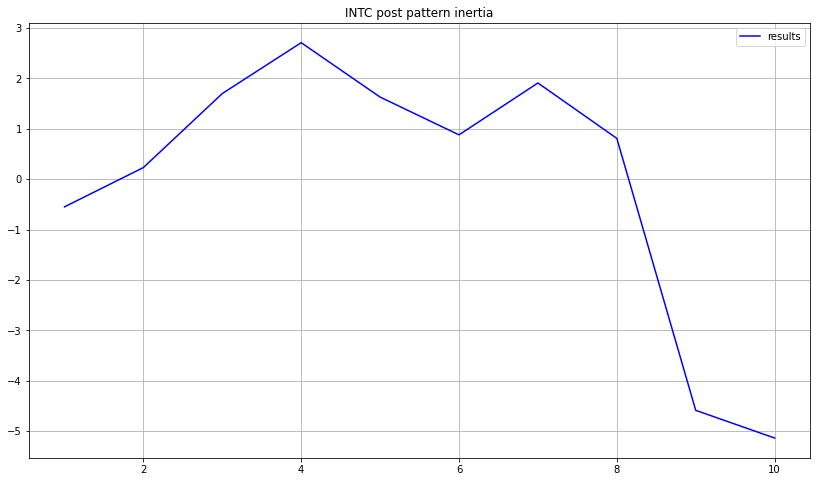


Pattern analysis on: JNJ

Occurrences: 1 

DatetimeIndex(['2020-07-22'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.6 average of 0.6 with 1 winning trades and 0 loosing trades
After: 2 days: 2.09 average of 2.09 with 1 winning trades and 0 loosing trades
After: 3 days: 3.03 average of 3.03 with 1 winning trades and 0 loosing trades
After: 4 days: 3.38 average of 3.38 with 1 winning trades and 0 loosing trades
After: 5 days: 3.67 average of 3.67 with 1 winning trades and 0 loosing trades
After: 6 days: 3.37 average of 3.37 with 1 winning trades and 0 loosing trades
After: 7 days: 4.45 average of 4.45 with 1 winning trades and 0 loosing trades
After: 8 days: 2.86 average of 2.86 with 1 winning trades and 0 loosing trades
After: 9 days: 2.99 average of 2.99 with 1 winning trades and 0 loosing trades
After: 10 days: 1.81 average of 1.81 with 1 winning trades and 0 loosing trades


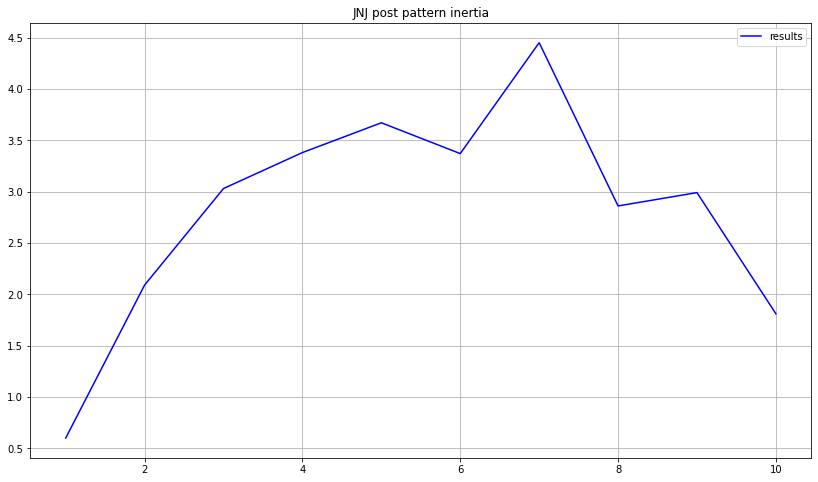


Pattern analysis on: JPM

Occurrences: 5 

DatetimeIndex(['2010-03-26', '2010-03-29', '2014-01-17', '2014-09-23',
               '2015-05-06'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.65 average of -0.13 with 2 winning trades and 3 loosing trades
After: 2 days: 0.53 average of 0.11 with 4 winning trades and 1 loosing trades
After: 3 days: 0.68 average of 0.14 with 3 winning trades and 2 loosing trades
After: 4 days: 1.79 average of 0.36 with 3 winning trades and 2 loosing trades
After: 5 days: 1.06 average of 0.21 with 2 winning trades and 3 loosing trades
After: 6 days: 0.37 average of 0.07 with 2 winning trades and 3 loosing trades
After: 7 days: 1.76 average of 0.35 with 2 winning trades and 3 loosing trades
After: 8 days: -1.37 average of -0.27 with 2 winning trades and 3 loosing trades
After: 9 days: -1.58 average of -0.32 with 2 winning trades and 3 loosing trades
After: 10 days: 1.02 average of 0.2 with 2 winning trades and 3 loosing tr

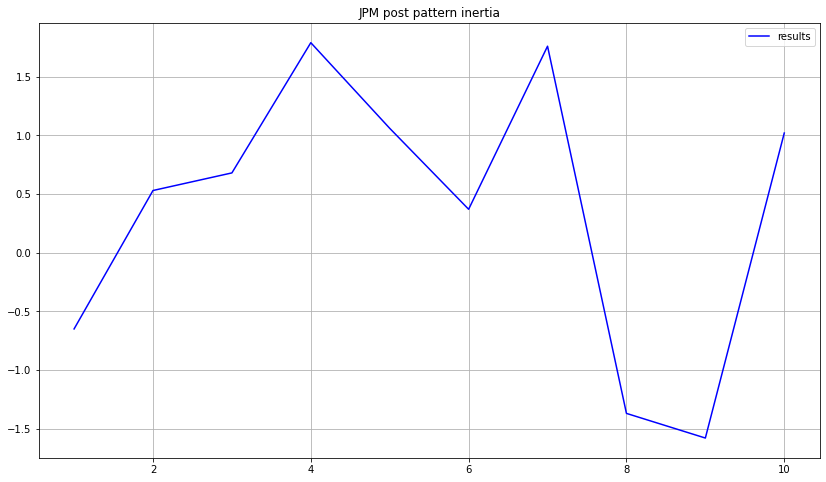


Pattern analysis on: MCD

Occurrences: 4 

DatetimeIndex(['2008-09-10', '2009-09-29', '2010-11-01', '2011-10-26'], dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -2.32 average of -0.58 with 0 winning trades and 4 loosing trades
After: 2 days: -1.37 average of -0.34 with 2 winning trades and 2 loosing trades
After: 3 days: -1.24 average of -0.31 with 2 winning trades and 2 loosing trades
After: 4 days: -0.89 average of -0.22 with 2 winning trades and 2 loosing trades
After: 5 days: -0.58 average of -0.14 with 2 winning trades and 2 loosing trades
After: 6 days: -1.98 average of -0.5 with 1 winning trades and 3 loosing trades
After: 7 days: -2.94 average of -0.74 with 1 winning trades and 3 loosing trades
After: 8 days: -2.37 average of -0.59 with 1 winning trades and 3 loosing trades
After: 9 days: -0.69 average of -0.17 with 2 winning trades and 2 loosing trades
After: 10 days: 1.02 average of 0.26 with 2 winning trades and 2 loosing trades


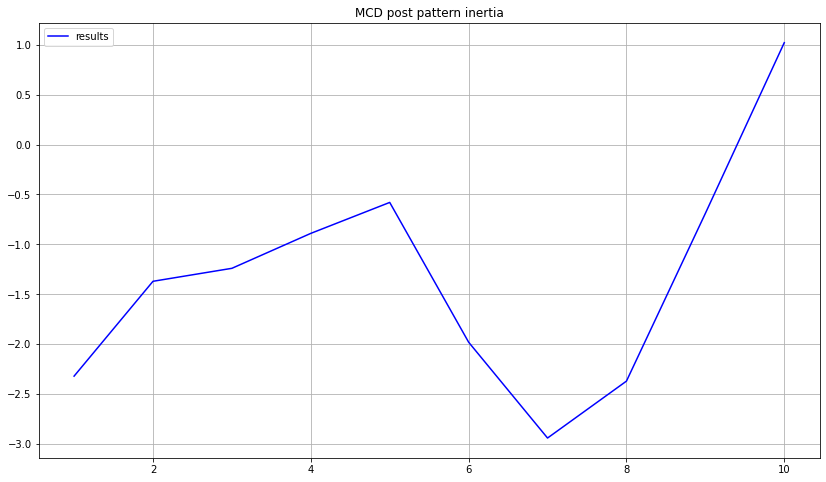


Pattern analysis on: MSFT

Occurrences: 8 

DatetimeIndex(['2009-04-30', '2009-06-17', '2010-03-26', '2015-12-03',
               '2016-03-31', '2017-09-19', '2020-01-22', '2020-06-24'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -4.78 average of -0.6 with 3 winning trades and 5 loosing trades
After: 2 days: 1.18 average of 0.15 with 3 winning trades and 5 loosing trades
After: 3 days: 4.19 average of 0.52 with 6 winning trades and 2 loosing trades
After: 4 days: -2.59 average of -0.32 with 5 winning trades and 3 loosing trades
After: 5 days: -5.76 average of -0.72 with 5 winning trades and 3 loosing trades
After: 6 days: -11.87 average of -1.48 with 5 winning trades and 3 loosing trades
After: 7 days: -14.24 average of -1.78 with 5 winning trades and 3 loosing trades
After: 8 days: -18.61 average of -2.33 with 3 winning trades and 5 loosing trades
After: 9 days: -30.87 average of -3.86 with 2 winning trades and 6 loosing trades
After: 10 days: -31.

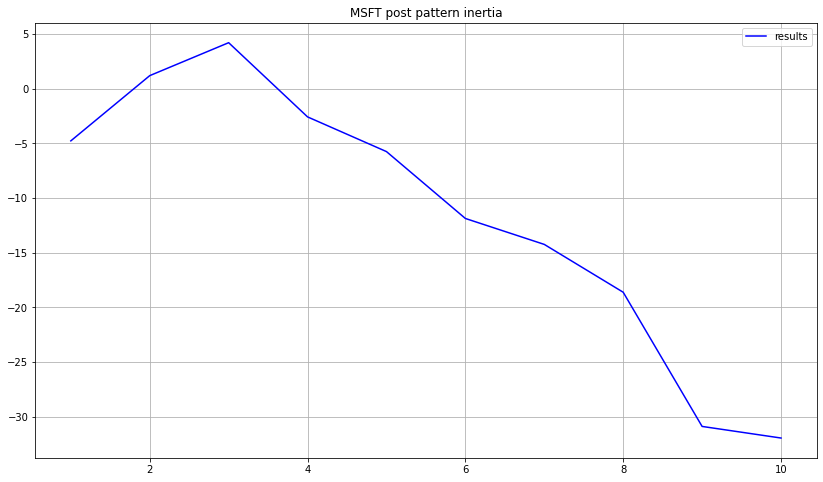


Pattern analysis on: NKE

Occurrences: 5 

DatetimeIndex(['2010-12-02', '2011-09-28', '2012-03-21', '2018-06-08',
               '2019-07-10'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.12 average of 0.02 with 2 winning trades and 3 loosing trades
After: 2 days: 1.06 average of 0.21 with 3 winning trades and 2 loosing trades
After: 3 days: 1.34 average of 0.27 with 4 winning trades and 1 loosing trades
After: 4 days: 1.1 average of 0.22 with 4 winning trades and 1 loosing trades
After: 5 days: 0.66 average of 0.13 with 4 winning trades and 1 loosing trades
After: 6 days: 0.35 average of 0.07 with 3 winning trades and 2 loosing trades
After: 7 days: 2.36 average of 0.47 with 4 winning trades and 1 loosing trades
After: 8 days: 1.69 average of 0.34 with 3 winning trades and 2 loosing trades
After: 9 days: 2.04 average of 0.41 with 3 winning trades and 2 loosing trades
After: 10 days: 1.87 average of 0.37 with 3 winning trades and 2 loosing trades


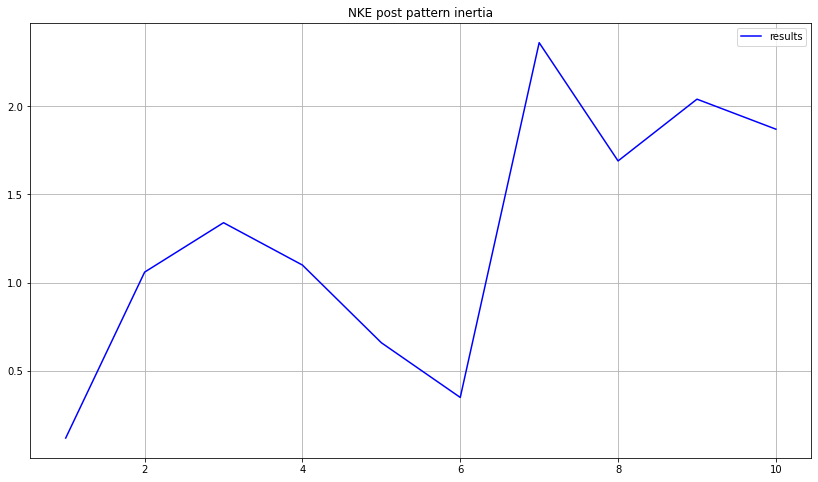


Basket analysis:
Positive inertia after 1 bars: ['MMM', 'BA', 'CVX', 'HD', 'IBM', 'JNJ', 'NKE']
Positive inertia after 2 bars: ['BA', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MSFT', 'NKE']
Positive inertia after 3 bars: ['BA', 'GS', 'IBM', 'INTC', 'JNJ', 'JPM', 'MSFT', 'NKE']
Positive inertia after 4 bars: ['AXP', 'BA', 'CSCO', 'XOM', 'GS', 'IBM', 'INTC', 'JNJ', 'JPM', 'NKE']
Positive inertia after 5 bars: ['BA', 'CSCO', 'XOM', 'GS', 'IBM', 'INTC', 'JNJ', 'JPM', 'NKE']
Positive inertia after 6 bars: ['AXP', 'CSCO', 'IBM', 'INTC', 'JNJ', 'JPM', 'NKE']
Positive inertia after 7 bars: ['AXP', 'CSCO', 'XOM', 'GS', 'IBM', 'INTC', 'JNJ', 'JPM', 'NKE']
Positive inertia after 8 bars: ['CVX', 'CSCO', 'GS', 'IBM', 'INTC', 'JNJ', 'NKE']
Positive inertia after 9 bars: ['CSCO', 'GS', 'IBM', 'JNJ', 'NKE']
Positive inertia after 10 bars: ['CVX', 'CSCO', 'GS', 'IBM', 'JNJ', 'JPM', 'MCD', 'NKE']


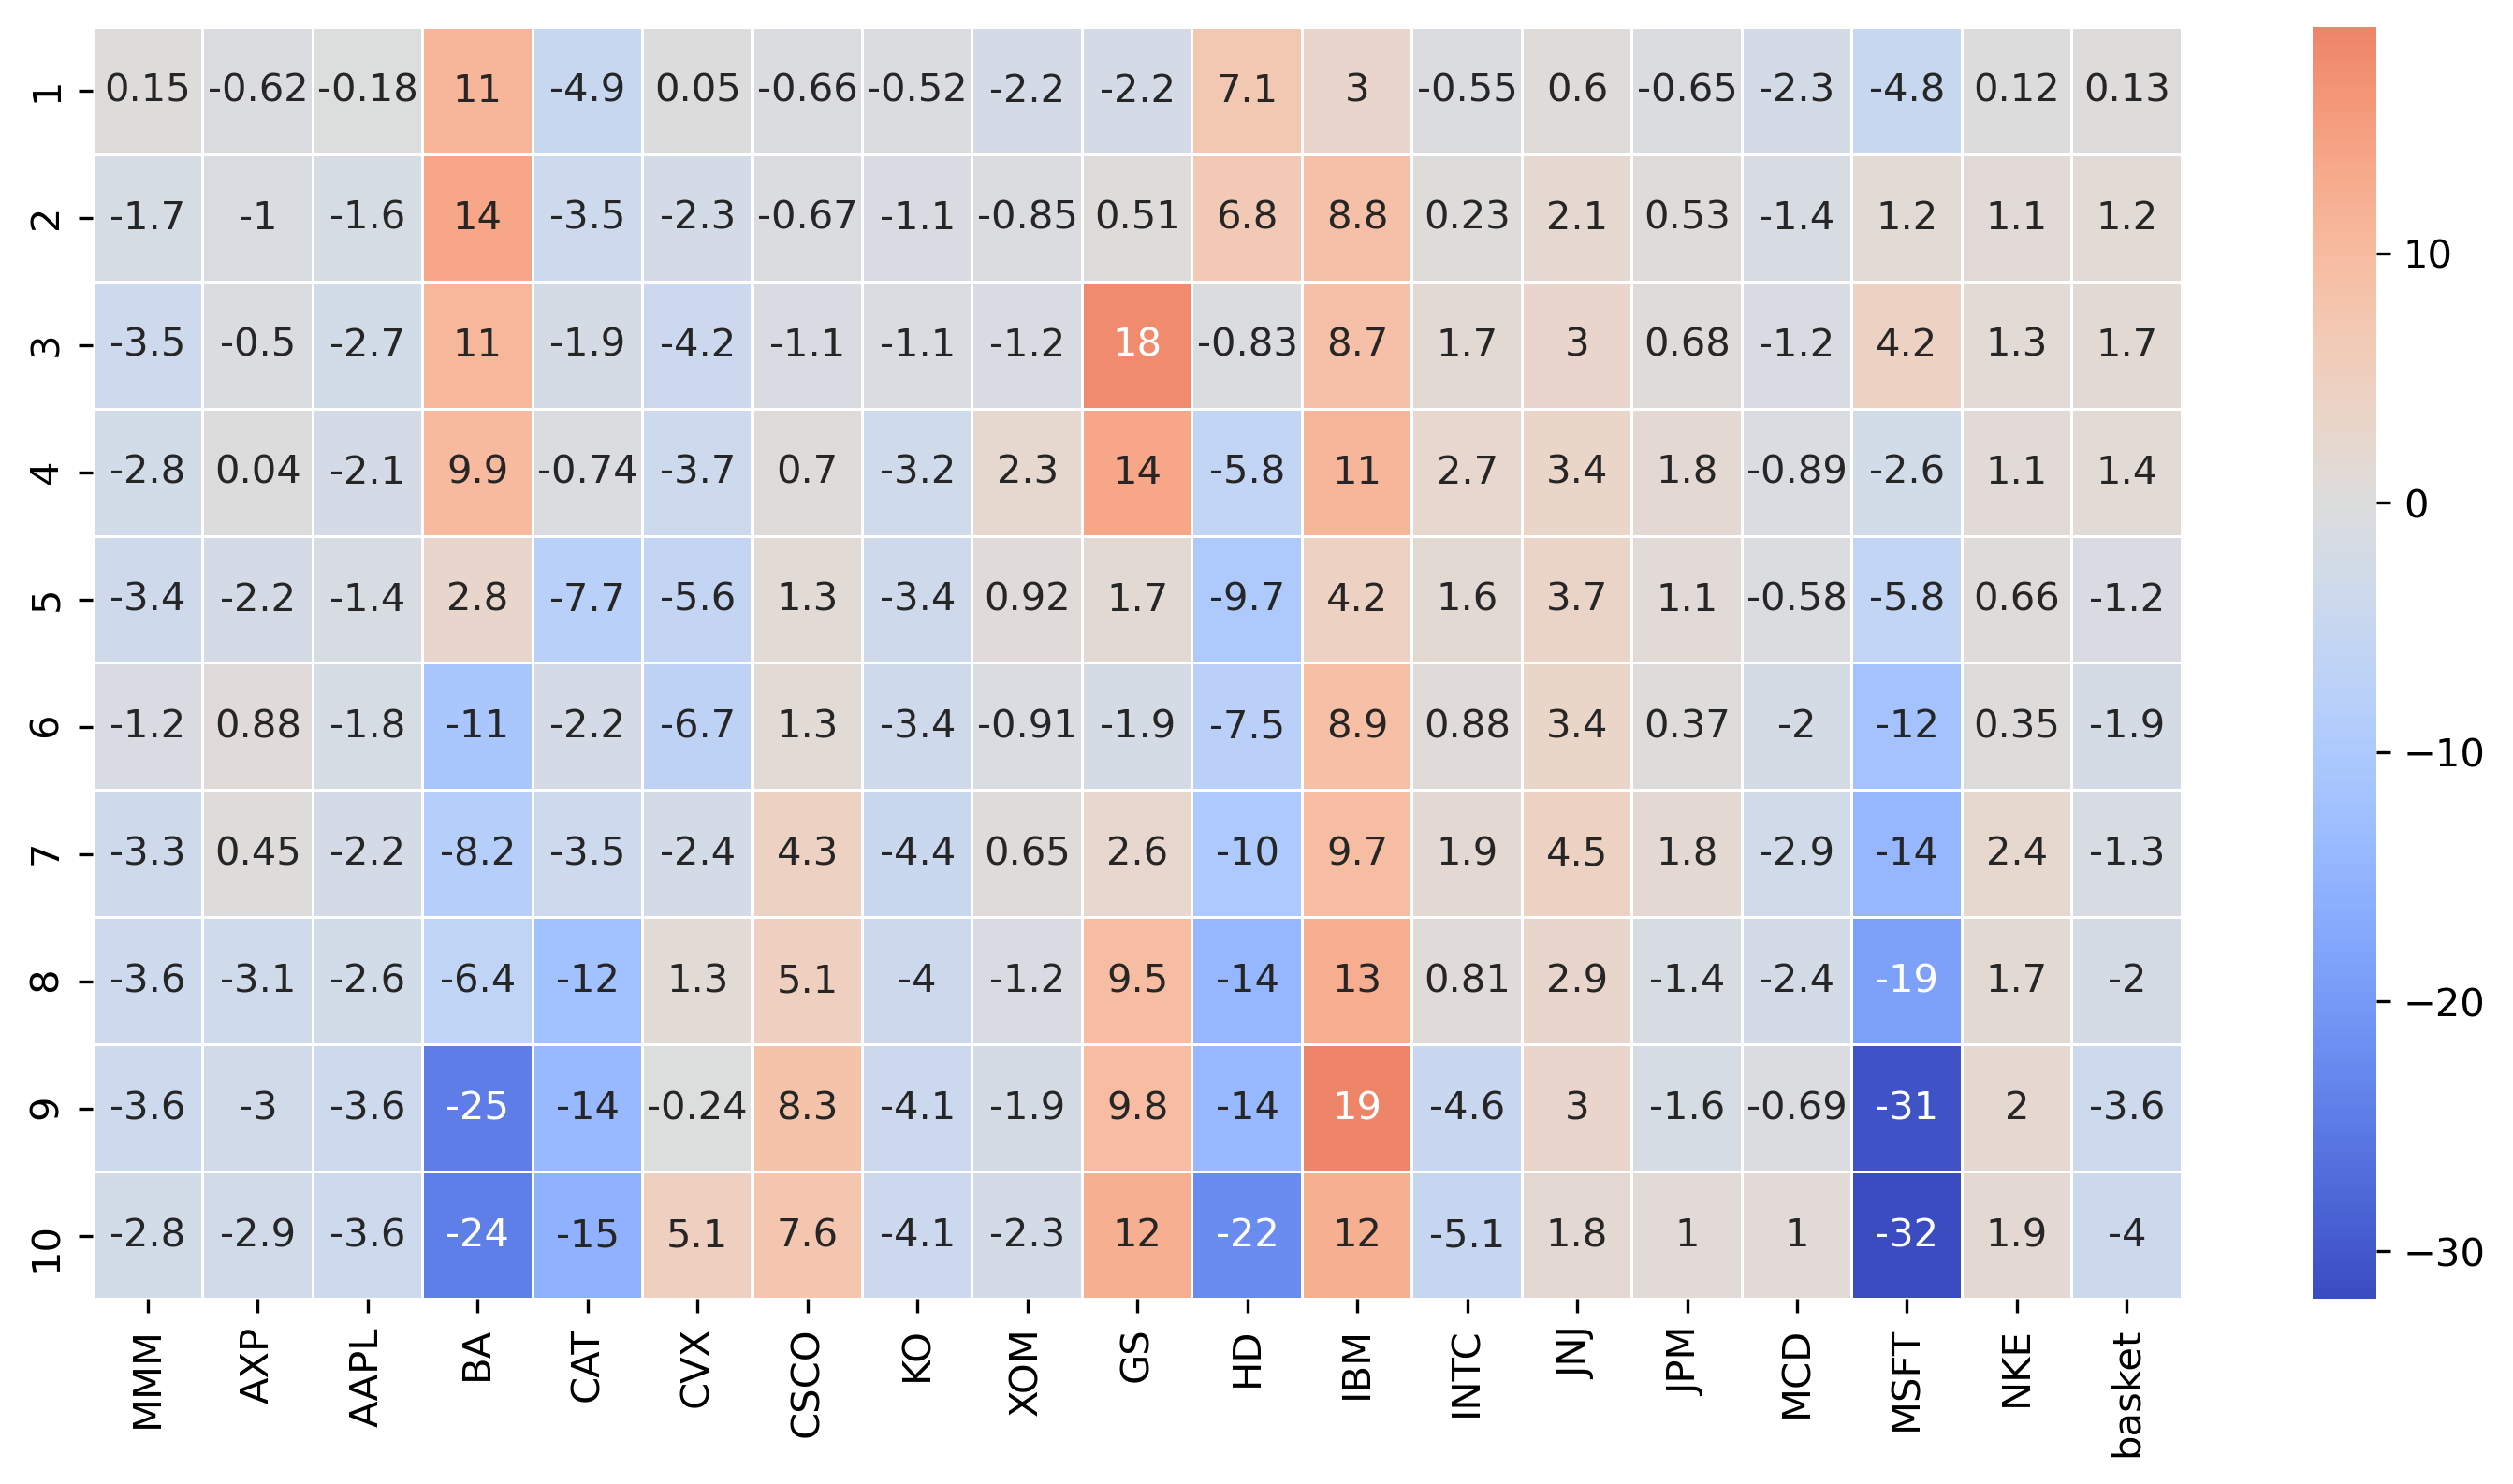

In [10]:
basket_results = pd.DataFrame(index = range(1,days_after + 1))

for ticker in tickerlist.split(","):

    print("Pattern analysis on: " + ticker + "\n")

    dataset = create_asset_dataset(matrix)
    
    pattern = (dataset.high.shift(1) > dataset.BBU.shift(1)) &\
              (dataset.close.shift(1) < dataset.BBU.shift(1)) &\
              (dataset.close_pos.shift(1) < 30) & (dataset.open_pos.shift(1) < 30) &\
              (dataset.range_perc.shift(1) > 1) &\
              (dataset.low < dataset.low.shift(1)) & (dataset.open >= dataset.low.shift(1))
    
    results = pattern_stats(dataset, pattern, "short", days_after, ticker)
    
    if show_patterns == True:
        plot_patterns(dataset,results[0],3,days_after)
        
    basket_results[ticker] = results[1]
        
    print("")
    
print("Basket analysis:")
positive_effect(basket_results)
    
basket_results["basket"] = basket_results.mean(axis = 1)
basket_results

plt.figure(figsize = [12,6], dpi = 300)
plt.xticks(rotation = 90)
ax = sns.heatmap(basket_results, annot=True, cmap="coolwarm", center = 0, linewidths=.5)

In [11]:
basket_results.iplot(title = "Pattern inertia")